In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, multilabel_confusion_matrix, hamming_loss,
    make_scorer
)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from kmodes.kprototypes import KPrototypes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from datetime import datetime
import pickle
import plotly.graph_objects as go
import warnings
from collections import Counter
import ppscore as pps
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv("dataset.csv")

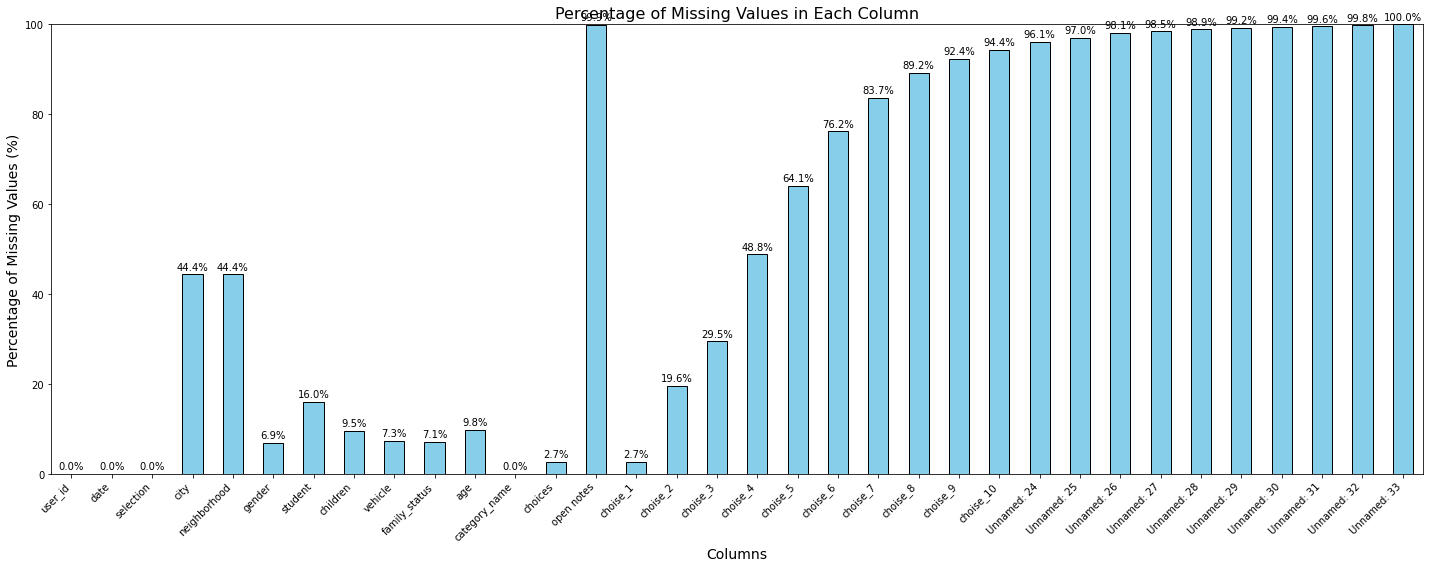

In [4]:
# Calculate the percentage of missing values in each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Create a bar plot to visualize missing values percentage
plt.figure(figsize=(20, 8))
ax = missing_percentage.plot(kind='bar', color='skyblue', edgecolor='black')

# Add value labels above each bar
for i, val in enumerate(missing_percentage):
    ax.text(i, val + 1, f'{val:.1f}%', ha='center', fontsize=10)

# Add title and axis labels
plt.title('Percentage of Missing Values in Each Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [5]:
# Calculate the PPS (Predictive Power Score)
pps_score = pps.score(df, 'choices', 'category_name')['ppscore']

# Print the PPS score
print("PPS Score:", pps_score)

PPS Score: 0.611665623768091


In [6]:
# Drop unnecessary columns from the DataFrame and create a cleaned version
df_cleaned = df.drop(columns=['city', 'open notes', 'choise_1', 'choise_2',
       'choise_3', 'choise_4', 'choise_5', 'choise_6', 'choise_7', 'choise_8',
       'choise_9', 'choise_10', 'choices'])

In [7]:
print(df.dtypes)

user_id            int64
date              object
selection         object
city              object
neighborhood      object
gender            object
student           object
children          object
vehicle           object
family_status     object
age              float64
category_name     object
choices           object
open notes        object
choise_1          object
choise_2          object
choise_3          object
choise_4          object
choise_5          object
choise_6          object
choise_7          object
choise_8          object
choise_9          object
choise_10         object
Unnamed: 24       object
Unnamed: 25       object
Unnamed: 26       object
Unnamed: 27       object
Unnamed: 28       object
Unnamed: 29       object
Unnamed: 30       object
Unnamed: 31       object
Unnamed: 32       object
Unnamed: 33       object
dtype: object


In [8]:
# Remove all columns with the name "Unnamed"
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('^Unnamed')]

In [9]:
# Check value consistency across all columns except 'category_name' for each 'user_id'
columns_to_check = [col for col in df_cleaned.columns if col not in ['user_id', 'category_name']]
consistent_users = df_cleaned.groupby('user_id')[columns_to_check].nunique()

# Identify users with inconsistent values in the columns (should be 1 in all columns)
inconsistent_users = consistent_users[(consistent_users > 1).any(axis=1)]

# Aggregate rows by 'user_id' and save the list of categories in a new column
agg_dict = {col: 'first' for col in columns_to_check}  # Keep the first value for each column
agg_dict['category_name'] = lambda x: list(set(x))  # Create a list of unique categories

df_cleaned = df_cleaned.groupby('user_id').agg(agg_dict).reset_index()

In [10]:
# Define the columns to check for missing values
columns_to_check = ['neighborhood', 'gender', 'student', 'children', 'vehicle', 'family_status', 'age']

# Count the number of missing values in each row
missing_values_count = df_cleaned[columns_to_check].isna().sum(axis=1)

# Retain only rows with fewer than 4 missing values
df_cleaned = df_cleaned[missing_values_count < 4]

In [11]:
df_cleaned.head()

user_id                date selection neighborhood gender student children  \
0        1  11022019  10:05:26       בית     א. תעשיה    זכר      כן      אין   
3        8  11022019  18:25:35       עיר         None   None      לא      אין   
4        9  11022019  20:37:18       בית     נווה נוי   None    None       יש   
6       15  12022019  07:38:20       בית            ט   None      לא      אין   
9       24  12022019  11:15:52     עבודה            א   None      לא      אין   

  vehicle family_status   age  \
0     אין        single  37.0   
3     אין         widow  14.0   
4    None       married  34.0   
6     אין        single  95.0   
9     אין      divorced  97.0   

                                       category_name  
0                     [הורים וילדים, מצרכים ומוצרים]  
3  [מסעדות ובתי קפה, אופנה וטיפוח, דברים לבית, מצ...  
4  [מסעדות ובתי קפה, שירותים מקצועיים, קופת חולים...  
6  [תחביבים, ספורט ופנאי, אופנה וטיפוח, הורים ויל...  
9  [תחביבים, ספורט ופנאי, קופת חולים ופארם, בחירה...

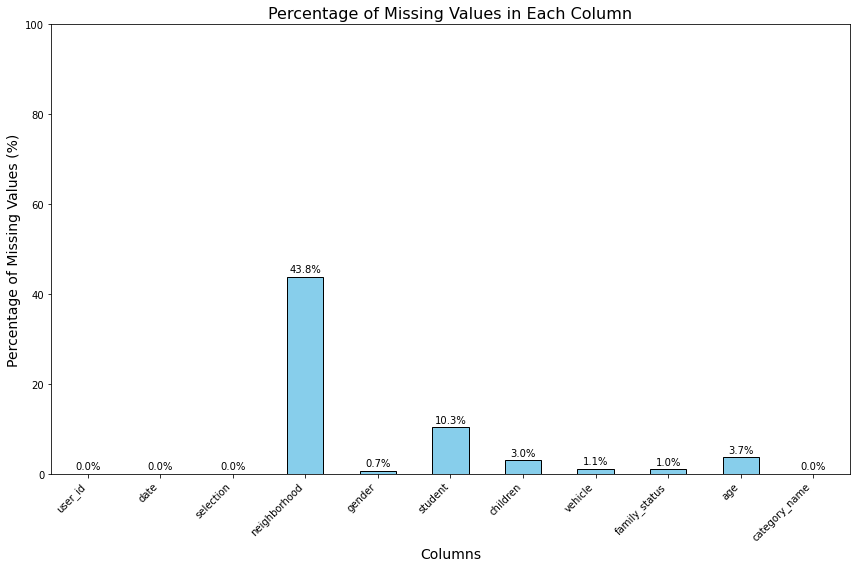

In [12]:
# Calculate the percentage of missing values in each column
missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# Create a bar plot to visualize the percentage of missing values
plt.figure(figsize=(12, 8))
ax = missing_percentage.plot(kind='bar', color='skyblue', edgecolor='black')

# Add value labels above each bar
for i, val in enumerate(missing_percentage):
    ax.text(i, val + 1, f'{val:.1f}%', ha='center', fontsize=10)

# Add titles and axis labels
plt.title('Percentage of Missing Values in Each Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
pip install ppscore

Note: you may need to restart the kernel to use updated packages.


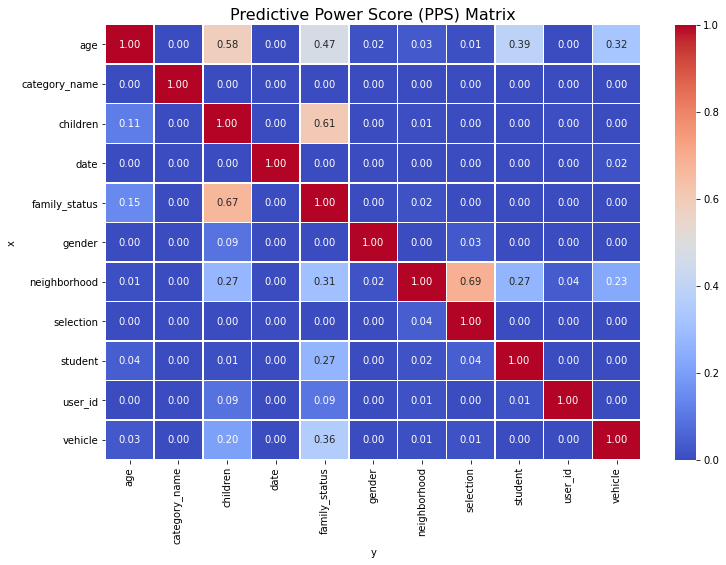

In [14]:
warnings.filterwarnings("ignore")

import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the PPS matrix
pps_matrix = pps.matrix(df_cleaned)

# Focus on the PPS matrix: Create a pivot table with the adjusted matrix
pps_heatmap = pps_matrix.pivot(index='x', columns='y', values='ppscore')

# Create a Heatmap to visualize the PPS matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pps_heatmap, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Predictive Power Score (PPS) Matrix", fontsize=16)
plt.show()

# we want to check if the model should predict multi label or one label classifiction
import string
df_cleaned['list_length'] = df_cleaned['category_name'].apply(len)
df_cleaned['list_length'].value_counts()

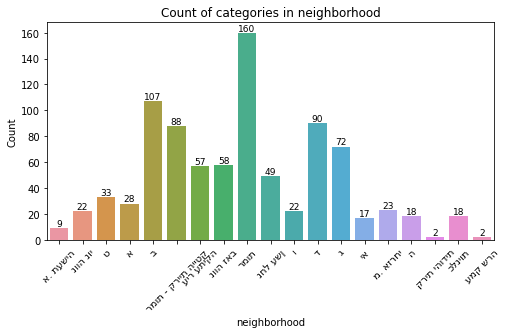

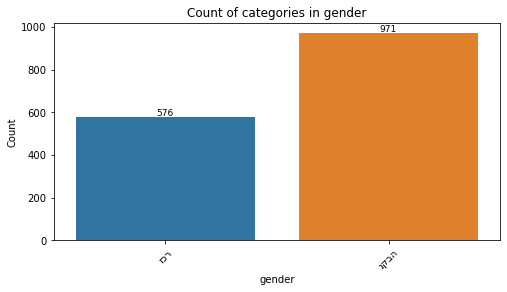

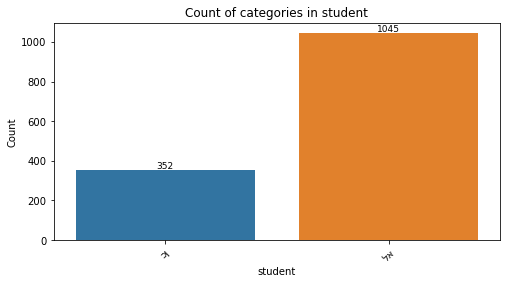

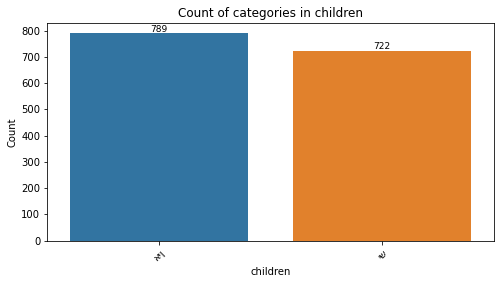

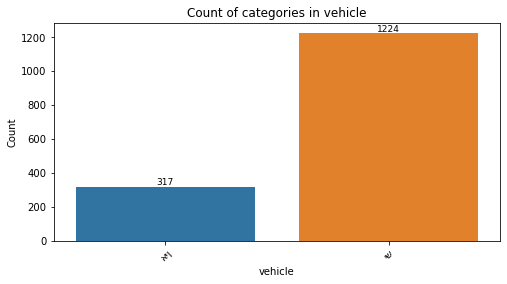

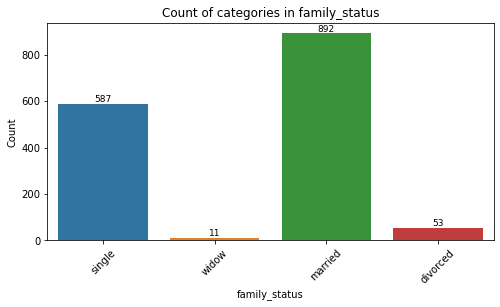

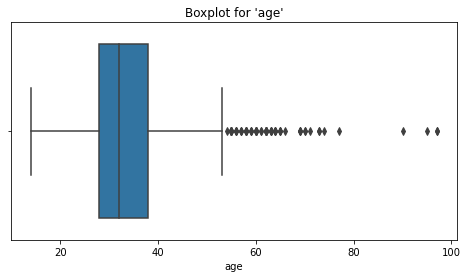

In [15]:
# List of columns to check for anomalies
categorical_columns = ['neighborhood', 'gender', 'student', 'children', 'vehicle', 'family_status']

# Countplot for categorical columns with added numbers above the bars
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x=df_cleaned[col])
    plt.title(f"Count of categories in {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # Add numbers above the bars
    for patch in ax.patches:
        count = int(patch.get_height())
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(count),
                 ha='center', va='bottom', fontsize=9)

    plt.show()

# Boxplot for the numeric column 'age'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['age'])
plt.title("Boxplot for 'age'")
plt.xlabel('age')

plt.show()

מילוי ערכים חסרים לעמודה של גיל

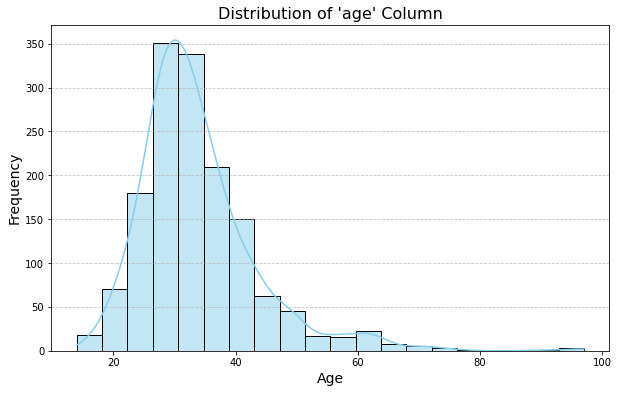

In [16]:
def plot_age_distribution(dataframe, column_name='age'):
    """
    Function to display the distribution of the 'age' column.
    :param dataframe: DataFrame containing the 'age' column.
    :param column_name: Name of the column to display the distribution (default: 'age').
    """
    if column_name not in dataframe.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(dataframe[column_name], kde=True, bins=20, color='skyblue')
    plt.title(f"Distribution of '{column_name}' Column", fontsize=16)
    plt.xlabel("Age", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
plot_age_distribution(df_cleaned, column_name='age')

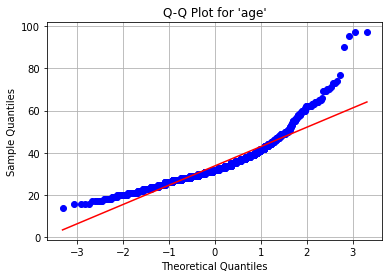

In [17]:
def plot_qq_plot(df, column_name):
    """
    Function to display a Q-Q Plot for a specific column.
    :param df: DataFrame containing the column to analyze.
    :param column_name: Name of the column for which to create the Q-Q Plot.
    """
    data = df[column_name].dropna()  # Remove missing values
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for '{column_name}'")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid()
    plt.show()

# Call the function
plot_qq_plot(df_cleaned, "age")

The graphs indicated that the `age` column does not follow a perfect normal distribution but has a bell-like shape. Therefore, we filled the missing values using the mean or median within groups defined by gender and family status. This approach preserved logical relationships in the data while avoiding overemphasis on outliers.

In [18]:
# Function to fill missing values in the 'age' column based on group averages
def fill_age_by_group_optimized(df_cleaned, group_columns):
    # Calculate the average age for each group
    age_means_df = df_cleaned.groupby(group_columns)['age'].mean().reset_index()
    age_means_df.rename(columns={'age': 'age_mean'}, inplace=True)

    # Merge group averages back into the original DataFrame
    df_cleaned = df_cleaned.merge(age_means_df, on=group_columns, how='left')

    # Fill missing values in the 'age' column using group averages
    df_cleaned['age'] = df_cleaned['age'].fillna(df_cleaned['age_mean'])

    # Drop the helper column
    df_cleaned = df_cleaned.drop(columns=['age_mean'])

    return df_cleaned

# Define columns for groupings
group_columns = ['gender', 'family_status', 'children']

# Fill missing values based on all group combinations
df_cleaned = fill_age_by_group_optimized(df_cleaned, group_columns)

# Additional filling for pairwise groupings if missing values remain
group_columns_pairs = [
    ['gender', 'family_status'],
    ['gender', 'children'],
    ['family_status', 'children']
]

for group_pair in group_columns_pairs:
    df_cleaned = fill_age_by_group_optimized(df_cleaned, group_pair)

# Final filling with overall median if missing values still exist
if df_cleaned['age'].isna().sum() > 0:
    df_cleaned['age'] = df_cleaned['age'].fillna(df_cleaned['age'].median())

# Convert the 'age' column to integers
df_cleaned['age'] = df_cleaned['age'].round().astype(int)

Filling missing values in the 'children' column.

In [19]:
# Function to calculate the average or mode for grouping categories in the 'children' column (textual values)
def fill_children_by_group(df_cleaned, group_columns, min_group_size=5):
    """
    Fill missing values in the 'children' column based on group modes or a global mode for small groups.
    :param df_cleaned: The DataFrame with missing values in the 'children' column.
    :param group_columns: List of columns to define groups for filling the 'children' column.
    :param min_group_size: Minimum size of a group to use its mode for filling (default: 5).
    :return: DataFrame with filled 'children' column.
    """
    # Calculate the mode (most frequent value) of 'children' for each group
    children_modes = df_cleaned.groupby(group_columns)['children'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    
    # Calculate the size of each group
    group_sizes = df_cleaned.groupby(group_columns).size()
    
    # Fill missing values in the 'children' column based on the group
    def fill_children(row):
        if pd.isna(row['children']):  # If the value is missing
            # Find the group based on the defined columns
            group = tuple(row[group_columns])
            # Check if the group size is too small
            if group_sizes.get(group, 0) < min_group_size:
                # If the group is too small, return the global mode
                return df_cleaned['children'].mode()[0]
            else:
                # If the group is large enough, use the group mode
                return children_modes.get(group, None)
        else:
            return row['children']  # If there is a value, keep it

    # Apply the function to all rows
    df_cleaned['children'] = df_cleaned.apply(fill_children, axis=1)
    return df_cleaned

# Define the columns for grouping
group_columns = ['family_status', 'age']  # Grouping by family status and age

# Fill missing values in the 'children' column based on grouping
df_cleaned = fill_children_by_group(df_cleaned, group_columns)

# Function to fill missing values in the 'children' column based on family status and age
def fill_children_by_group(df_cleaned):
    """
    Fill missing values in the 'children' column using predefined conditions.
    :param df_cleaned: The DataFrame with missing values in the 'children' column.
    :return: DataFrame with filled 'children' column.
    """
    def fill_children(row):
        if pd.isna(row['children']):  # If the 'children' value is missing
            # If family status is 'single', fill with 'אין' (no children)
            if row['family_status'] == 'single':
                return 'אין'
            # If family status is 'married' or 'divorced' and age is 27 or older, fill with 'יש' (has children)
            elif row['family_status'] in ['married', 'divorced'] and row['age'] >= 27:
                return 'יש'
            # If family status is 'married' or 'divorced' and age is below 27, fill with 'אין' (no children)
            elif row['family_status'] in ['married', 'divorced'] and row['age'] < 27:
                return 'אין'
        return row['children']  # If a value exists, keep it as is

    # Apply the function to all rows
    df_cleaned['children'] = df_cleaned.apply(fill_children, axis=1)
    return df_cleaned

# Apply the function to the DataFrame
df_cleaned = fill_children_by_group(df_cleaned)

Filling missing values in the 'family_status' column.

In [20]:
def fill_family_status(df_cleaned):
    """
    Fill missing values in the 'family_status' column based on logical conditions.
    """
    def fill_status(row):
        # If the value in the 'family_status' column is missing
        if pd.isna(row['family_status']):
            # If the 'children' column indicates 'יש' (has children), assume 'married' or 'divorced'
            if row['children'] == 'יש':
                # If the age is 30 or above, assume 'married' or 'divorced'
                if row['age'] >= 30:
                    return 'married'  # You can also assume 'divorced' depending on context
                else:
                    return 'married'  # You may choose 'divorced' if young age fits the context
            # If the 'children' column indicates 'אין' (no children), assume 'single'
            elif row['children'] == 'אין':
                return 'single'
        return row['family_status']  # If a status exists, keep it as is

    # Apply the function to all rows in the DataFrame
    df_cleaned['family_status'] = df_cleaned.apply(fill_status, axis=1)
    
    # Combine categories - replace 'widow' with 'divorced'
    df_cleaned['family_status'] = df_cleaned['family_status'].replace({'widow': 'divorced'})
    
    return df_cleaned

# Apply the function to fill missing family status
df_cleaned = fill_family_status(df_cleaned)

Filling missing values in the 'gender' column.

In [21]:
# 1. Create a unique key for each combination of family_status, age, and children
df_cleaned['group_key'] = df_cleaned[['family_status', 'age', 'children']].apply(tuple, axis=1)

# 2. Calculate the most frequent value (mode) for each group
group_modes = df_cleaned.groupby('group_key')['gender'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)

# 3. Fill missing values using the mode of the group
df_cleaned['gender'] = df_cleaned.apply(
    lambda row: group_modes[row['group_key']] if pd.isna(row['gender']) else row['gender'], axis=1
)

# 4. Drop the temporary key column
df_cleaned.drop(columns=['group_key'], inplace=True)

# 5. Check if there are still missing values after the initial filling
missing_count = df_cleaned['gender'].isna().sum()

# 6. Fill remaining missing values with random values from the existing non-missing values in the column
if missing_count > 0:
    non_null_genders = df_cleaned['gender'].dropna().unique()
    df_cleaned['gender'] = df_cleaned['gender'].apply(
        lambda x: np.random.choice(non_null_genders) if pd.isna(x) else x
    )

Filling missing values in the 'vehicle' column.

In [22]:
# 2. Define data for prediction (only rows with a value in 'vehicle')
df_with_vehicle = df_cleaned[df_cleaned['vehicle'].notna()]
df_missing_vehicle = df_cleaned[df_cleaned['vehicle'].isna()]

# 3. Define X and y variables
X = df_with_vehicle[['age', 'family_status']]
y = df_with_vehicle['vehicle']

# Convert categorical variables to numbers for X
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Use 'sparse_output' instead of 'sparse'
family_status_encoded = encoder.fit_transform(X[['family_status']])
family_status_columns = encoder.get_feature_names_out(['family_status'])

# Add encoded columns to X and remove the original column
X = X.drop(columns=['family_status'])
X[family_status_columns] = family_status_encoded

# 4. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Create and train a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# 6. Check model accuracy
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy}")

# 7. Predict missing values in 'vehicle'
# Define X_missing
X_missing = df_missing_vehicle[['age', 'family_status']]

# Check if X_missing is not empty
if not X_missing.empty:
    # Convert categorical variables to numbers for X_missing
    family_status_missing_encoded = encoder.transform(X_missing[['family_status']])
    family_status_missing_columns = encoder.get_feature_names_out(['family_status'])

    # Add encoded columns to X_missing and remove the original column
    X_missing = X_missing.drop(columns=['family_status'])
    X_missing[family_status_missing_columns] = family_status_missing_encoded

    # Align columns (if some columns are missing in X_missing)
    for col in X.columns:
        if col not in X_missing.columns:
            X_missing[col] = 0

    # Predict missing values
    predicted_vehicle = log_reg.predict(X_missing)

    # 8. Fill missing values in the 'vehicle' column
    df_cleaned.loc[df_cleaned['vehicle'].isna(), 'vehicle'] = predicted_vehicle
else:
    print("No missing values to predict.")

Model accuracy: 0.8381877022653722


Filling missing values in the 'student' column.

In [23]:
# List of columns used to create the grouping for filling
grouping_columns = ['age', 'gender', 'family_status', 'vehicle']

# Function to fill missing values in the 'student' column
def fill_student(group, original_df):
    if group.mode().empty:  # If there is no clear mode in the group
        return group.fillna(original_df['student'].mode()[0])  # Use the overall most common value
    else:
        return group.fillna(group.mode()[0])  # Use the most common value within the group

# Fill missing values in the 'student' column based on groups
df_cleaned['student'] = df_cleaned.groupby(grouping_columns)['student'].apply(
    lambda group: fill_student(group, df_cleaned)
)

# Check if there are still missing values
missing_count_student = df_cleaned['student'].isna().sum()

# Handle remaining missing values (if any)
if missing_count_student > 0:
    most_common_student = df_cleaned['student'].mode()[0]  # The overall most common value
    df_cleaned['student'].fillna(most_common_student, inplace=True)

# Final check for missing values
final_missing_count_student = df_cleaned['student'].isna().sum()

Filling missing values in the 'neighborhood' column.

In [24]:
# Fill missing values in 'neighborhood' based on age groups
def fill_neighborhood_by_age(group):
    most_frequent = group['neighborhood'].mode()  # Find the most frequent value
    if not most_frequent.empty:
        group['neighborhood'] = group['neighborhood'].fillna(most_frequent[0])
    return group

# Group by age and fill missing values
df_cleaned = df_cleaned.groupby('age').apply(fill_neighborhood_by_age)

# Handle any remaining missing values (e.g., groups with no data)
non_null_values = df_cleaned['neighborhood'].dropna().unique()  # Get unique non-null values
df_cleaned['neighborhood'] = df_cleaned['neighborhood'].apply(
    lambda x: np.random.choice(non_null_values) if pd.isna(x) else x
)

# Replace specific values in 'neighborhood'
df_cleaned['neighborhood'] = df_cleaned['neighborhood'].replace({'עמק שרה': 'א. תעשיה'})
df_cleaned['neighborhood'] = df_cleaned['neighborhood'].replace({'קרית יהודית': 'נווה נוי'})

# Verify that there are no missing values left
if df_cleaned['neighborhood'].isna().sum() == 0:
    print("All missing values in 'neighborhood' have been filled successfully!")
else:
    print(f"There are still {df_cleaned['neighborhood'].isna().sum()} missing values in 'neighborhood'.")

All missing values in 'neighborhood' have been filled successfully!


In [25]:
# Handling the 'category_name' column: converting to numeric values
if 'category_name' in df_cleaned.columns:
    label_encoder = LabelEncoder()

    # Flatten the list to fit the LabelEncoder
    all_elements = [item for sublist in df_cleaned['category_name'] for item in sublist]

    # Fit the encoder on all unique elements
    label_encoder.fit(all_elements)

    # Function to encode each list in the Series
    def encode_list(lst):
        return label_encoder.transform(lst)

    # Apply encoding to each list
    df_cleaned['category_name'] = df_cleaned['category_name'].apply(encode_list)
    category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(category_mapping)

# Identifying textual columns excluding 'category_name'
non_numeric_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns
non_numeric_columns = non_numeric_columns.drop('category_name', errors='ignore')  # Remove 'category_name' from the list

{'אופנה וטיפוח': 0, 'בחירה חופשית': 1, 'דברים לבית': 2, 'הורים וילדים': 3, 'מסעדות ובתי קפה': 4, 'מצרכים ומוצרים': 5, 'קופת חולים ופארם': 6, 'שירותים מקצועיים': 7, 'תחביבים, ספורט ופנאי': 8}


In [26]:
data_clustering=df_cleaned.copy()


Statistics for 'age' after normalization:
count    1558.000000
mean        0.238930
std         0.116124
min         0.000000
25%         0.168675
50%         0.216867
75%         0.277108
max         1.000000
Name: age, dtype: float64


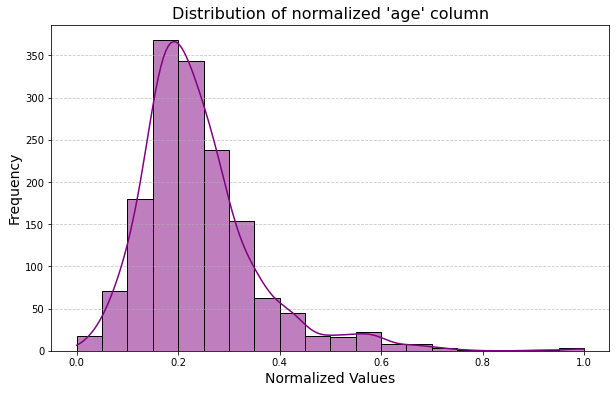

In [27]:
# Function to normalize the 'age' column between 0 and 1 and replace existing values
def normalize_age_inplace_minmax(dataframe, column_name='age'):
    """
    Normalize the 'age' column to a range between 0 and 1, replacing its existing values.
    :param dataframe: DataFrame containing the column.
    :param column_name: Name of the column to normalize (default: 'age').
    :return: DataFrame with the normalized 'age' column.
    """
    if column_name not in dataframe.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return dataframe
    
    # Use MinMaxScaler to normalize values between 0 and 1
    scaler = MinMaxScaler()
    dataframe[column_name] = scaler.fit_transform(dataframe[[column_name]])
    
    return dataframe

# Function to plot the distribution of the normalized column
def plot_normalized_age_distribution(dataframe, column_name='age'):
    """
    Display the distribution of the normalized column.
    :param dataframe: DataFrame containing the column.
    :param column_name: Name of the column to display (default: 'age').
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(dataframe[column_name], kde=True, bins=20, color='purple')
    plt.title(f"Distribution of normalized '{column_name}' column", fontsize=16)
    plt.xlabel("Normalized Values", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Normalize the 'age' column
df_cleaned = normalize_age_inplace_minmax(df_cleaned, column_name='age')

# Display statistics after normalization
print(f"\nStatistics for 'age' after normalization:\n{df_cleaned['age'].describe()}")

# Plot the distribution of the normalized 'age' column
plot_normalized_age_distribution(df_cleaned, column_name='age')

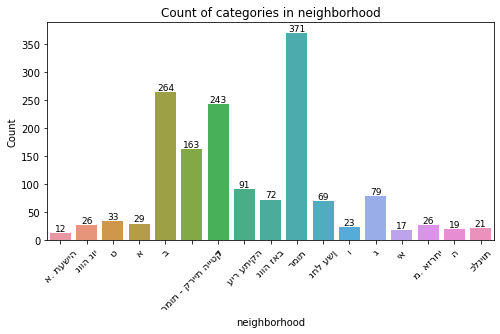

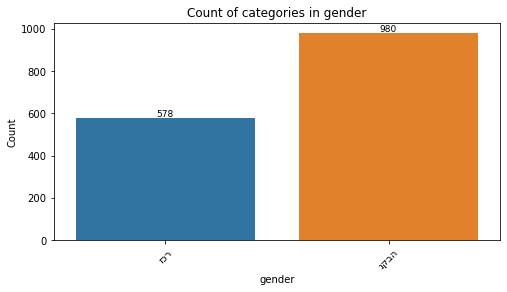

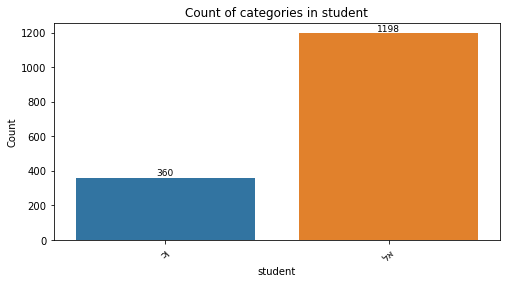

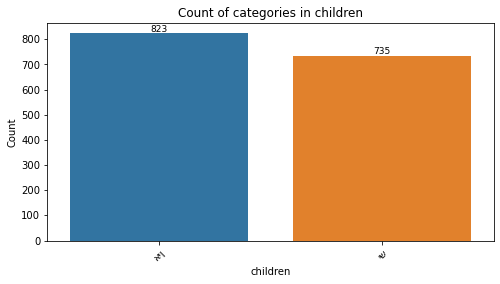

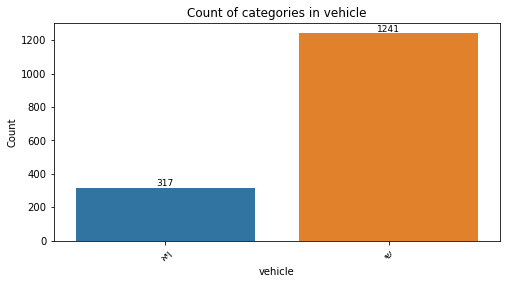

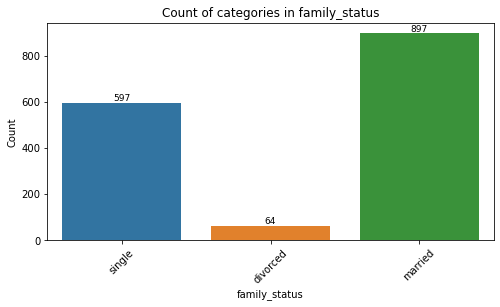

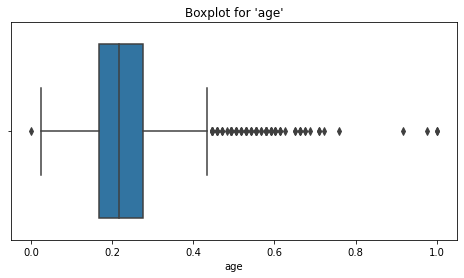

In [28]:
# List of columns to check for anomalies
categorical_columns = ['neighborhood', 'gender', 'student', 'children', 'vehicle', 'family_status']

# Countplot for categorical columns with numbers displayed above the bars
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(x=df_cleaned[col])
    plt.title(f"Count of categories in {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # Add numbers above the bars
    for patch in ax.patches:
        count = int(patch.get_height())
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(count),
                 ha='center', va='bottom', fontsize=9)

    plt.show()

# Boxplot for the numerical column 'age'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['age'])
plt.title("Boxplot for 'age'")
plt.xlabel('age')

plt.show()

Column: neighborhood
Rare categories (frequency < 0.01): ['א. תעשיה']

Column: gender
Rare categories (frequency < 0.01): []

Column: student
Rare categories (frequency < 0.01): []

Column: children
Rare categories (frequency < 0.01): []

Column: vehicle
Rare categories (frequency < 0.01): []

Column: family_status
Rare categories (frequency < 0.01): []

Number of anomalies detected in age using Isolation Forest: 75
Number of anomalies detected in age using IQR: 87



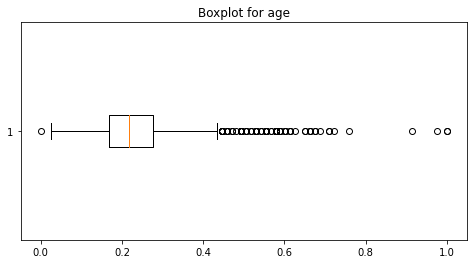

Categorical Anomalies:
neighborhood: ['א. תעשיה']
gender: []
student: []
children: []
vehicle: []
family_status: []

Numerical Anomalies:
Isolation Forest Anomalies:
      user_id                date selection neighborhood gender student  \
1           8  11022019  18:25:35       עיר     נווה נוי    זכר      לא   
3          15  12022019  07:38:20       בית            ט   נקבה      לא   
4          24  12022019  11:15:52     עבודה            א   נקבה      לא   
168       283  12022019  14:54:07       עיר            ו    זכר      לא   
209       369  12022019  15:49:41       בית         רמות    זכר      לא   
...       ...                 ...       ...          ...    ...     ...   
1495     2375  14022019  10:14:01       עיר     מ. אזרחי    זכר      לא   
1508     2390  14022019  11:01:29       בית            ט    זכר      לא   
1516     2399  14022019  11:07:32       בית      נחל עשן   נקבה      לא   
1517     2400  14022019  11:11:35       עיר            ב    זכר      לא   
1549     

In [29]:
# Detect anomalies in categorical columns
def detect_categorical_anomalies(df, categorical_columns, threshold=0.01):
    """
    Detect rare categories in categorical columns based on a frequency threshold.
    :param df: DataFrame containing the data.
    :param categorical_columns: List of categorical columns to check.
    :param threshold: Frequency threshold below which a category is considered rare (default: 0.01).
    :return: Dictionary of rare categories for each column.
    """
    anomalies = {}
    for col in categorical_columns:
        freq = df[col].value_counts(normalize=True)  # Calculate category frequency
        rare_categories = freq[freq < threshold].index.tolist()  # Identify rare categories
        anomalies[col] = rare_categories
        print(f"Column: {col}")
        print(f"Rare categories (frequency < {threshold}): {rare_categories}\n")
    return anomalies

# Detect anomalies in a numerical column
def detect_numerical_anomalies(df, numerical_column):
    """
    Detect anomalies in a numerical column using Isolation Forest and IQR.
    :param df: DataFrame containing the data.
    :param numerical_column: The numerical column to check for anomalies.
    :return: Dictionary containing anomalies detected using Isolation Forest and IQR.
    """
    anomalies = {}

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    isolation_forest_predictions = iso_forest.fit_predict(df[[numerical_column]])  # Predict without adding a column
    anomalies['isolation_forest'] = df[isolation_forest_predictions == -1]

    # IQR
    Q1 = df[numerical_column].quantile(0.25)
    Q3 = df[numerical_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    anomalies['iqr'] = df[(df[numerical_column] < lower_bound) | (df[numerical_column] > upper_bound)]

    print(f"Number of anomalies detected in {numerical_column} using Isolation Forest: {len(anomalies['isolation_forest'])}")
    print(f"Number of anomalies detected in {numerical_column} using IQR: {len(anomalies['iqr'])}\n")

    # Boxplot
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[numerical_column], vert=False)
    plt.title(f"Boxplot for {numerical_column}")
    plt.show()

    return anomalies

# Columns to check for anomalies
categorical_columns = ['neighborhood', 'gender', 'student', 'children', 'vehicle', 'family_status']
numerical_column = 'age'

# Identify anomalies in categorical columns
categorical_anomalies = detect_categorical_anomalies(df_cleaned, categorical_columns)

# Identify anomalies in the numerical column
numerical_anomalies = detect_numerical_anomalies(df_cleaned, numerical_column)

# Display anomalies found in categorical columns
print("Categorical Anomalies:")
for col, anomalies in categorical_anomalies.items():
    print(f"{col}: {anomalies}")

# Display anomalies found in the numerical column
print("\nNumerical Anomalies:")
print("Isolation Forest Anomalies:")
print(numerical_anomalies['isolation_forest'])
print("\nIQR Anomalies:")
print(numerical_anomalies['iqr'])

In [30]:
data_classification=df_cleaned.copy()

In [31]:
data_recommendations=df_cleaned.copy()

In [32]:
# 1. Check non-numeric columns
print("Non-numeric columns (object and category):")
non_numeric_columns = data_classification.select_dtypes(include=['object', 'category']).columns
print(non_numeric_columns)

# 2. Convert text to numeric values
label_encoder = LabelEncoder()

for col in non_numeric_columns:
    if col == 'date':  # Skip date columns
        pass
    elif col == 'category_name':  # Do not encode the 'category_name' column
        print(f"Skipping column '{col}'")
        continue
    else:  # Convert text to numeric categories
        encoder = LabelEncoder()
        data_classification[col] = encoder.fit_transform(data_classification[col].astype(str))

        # Print mapping for each column
        print(f"Mapping for column '{col}':")
        for original, encoded in zip(encoder.classes_, range(len(encoder.classes_))):
            print(f"  {original} -> {encoded}")
        print()

Non-numeric columns (object and category):
Index(['date', 'selection', 'neighborhood', 'gender', 'student', 'children',
       'vehicle', 'family_status', 'category_name'],
      dtype='object')
Mapping for column 'selection':
  בית -> 0
  עבודה -> 1
  עיר -> 2

Mapping for column 'neighborhood':
  א -> 0
  א. תעשיה -> 1
  ב -> 2
  ג -> 3
  ד -> 4
  ה -> 5
  ו -> 6
  ט -> 7
  יא -> 8
  כלניות -> 9
  מ. אזרחי -> 10
  נווה זאב -> 11
  נווה נוי -> 12
  נחל עשן -> 13
  עיר עתיקה -> 14
  רמות -> 15
  רמות - קריית הייטק -> 16

Mapping for column 'gender':
  זכר -> 0
  נקבה -> 1

Mapping for column 'student':
  כן -> 0
  לא -> 1

Mapping for column 'children':
  אין -> 0
  יש -> 1

Mapping for column 'vehicle':
  אין -> 0
  יש -> 1

Mapping for column 'family_status':
  divorced -> 0
  married -> 1
  single -> 2

Skipping column 'category_name'


In [33]:
# 1. Check non-numeric columns
print("Non-numeric columns (object and category):")
non_numeric_columns = data_clustering.select_dtypes(include=['object', 'category']).columns
print(non_numeric_columns)

# 2. Convert text to numeric values
label_encoder = LabelEncoder()

for col in non_numeric_columns:
    if col == 'date':  # Skip date columns
        pass
    elif col == 'category_name':  # Do not encode the 'category_name' column
        print(f"Skipping column '{col}'")
        continue
    else:  # Convert text to numeric categories
        encoder = LabelEncoder()
        data_clustering[col] = encoder.fit_transform(data_clustering[col].astype(str))

        # Print mapping for each column
        print(f"Mapping for column '{col}':")
        for original, encoded in zip(encoder.classes_, range(len(encoder.classes_))):
            print(f"  {original} -> {encoded}")
        print()

Non-numeric columns (object and category):
Index(['date', 'selection', 'neighborhood', 'gender', 'student', 'children',
       'vehicle', 'family_status', 'category_name'],
      dtype='object')
Mapping for column 'selection':
  בית -> 0
  עבודה -> 1
  עיר -> 2

Mapping for column 'neighborhood':
  א -> 0
  א. תעשיה -> 1
  ב -> 2
  ג -> 3
  ד -> 4
  ה -> 5
  ו -> 6
  ט -> 7
  יא -> 8
  כלניות -> 9
  מ. אזרחי -> 10
  נווה זאב -> 11
  נווה נוי -> 12
  נחל עשן -> 13
  עיר עתיקה -> 14
  רמות -> 15
  רמות - קריית הייטק -> 16

Mapping for column 'gender':
  זכר -> 0
  נקבה -> 1

Mapping for column 'student':
  כן -> 0
  לא -> 1

Mapping for column 'children':
  אין -> 0
  יש -> 1

Mapping for column 'vehicle':
  אין -> 0
  יש -> 1

Mapping for column 'family_status':
  divorced -> 0
  married -> 1
  single -> 2

Skipping column 'category_name'


In [34]:
data_classification = data_classification.drop(columns=['user_id', 'date'])

In [35]:
data_clustering = data_clustering.drop(columns=['user_id', 'date'])

In [36]:
data_recommendations = data_recommendations.drop(columns=['date'])

In [37]:
data_classification.head()

selection  neighborhood  gender  student  children  vehicle  family_status  \
0          0             1       0        0         0        0              2   
1          2            12       0        1         0        0              0   
2          0            12       1        1         1        1              1   
3          0             7       1        1         0        0              2   
4          1             0       1        1         0        0              0   

        age category_name  
0  0.277108        [3, 5]  
1  0.000000  [4, 0, 2, 5]  
2  0.240964  [4, 7, 6, 5]  
3  0.975904     [8, 0, 3]  
4  1.000000  [8, 6, 1, 5]

In [38]:
data_clustering.head()

selection  neighborhood  gender  student  children  vehicle  family_status  \
0          0             1       0        0         0        0              2   
1          2            12       0        1         0        0              0   
2          0            12       1        1         1        1              1   
3          0             7       1        1         0        0              2   
4          1             0       1        1         0        0              0   

   age category_name  
0   37        [3, 5]  
1   14  [4, 0, 2, 5]  
2   34  [4, 7, 6, 5]  
3   95     [8, 0, 3]  
4   97  [8, 6, 1, 5]

In [39]:
# Print all values in the 'age' column
print(data_clustering['age'])

0       37
1       14
2       34
3       95
4       97
        ..
1553    29
1554    22
1555    31
1556    58
1557    25
Name: age, Length: 1558, dtype: int32


## classification

In [40]:
!pip install xgboost

In [41]:
!pip install imblearn

In [42]:
!pip install catboost

In [43]:
!pip install lightgbm

In [44]:
# 1. Define targets and features
y = data_classification['category_name']  # Target column
X = data_classification.drop(columns=['category_name'])  # Feature columns

# Binarize the target column
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y)

# Normalize all columns except 'age'
columns_to_scale = [col for col in X.columns if col != 'age']
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# Define models
models = {
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=1.0,
        random_state=42,
        objective='binary:logistic'
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=2,
        min_samples_split=2,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=500,
        depth=4,
        learning_rate=0.01,
        random_state=42,
        verbose=0  # Suppress training output
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.01,
        random_state=42,
        verbose=-1
    )
}

# Variable to store feature importance for each model
feature_importance_results = {}

# Perform cross-validation and evaluate models
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    multi_model = MultiOutputClassifier(model)
    scorers = {
        "f1_micro": make_scorer(f1_score, average='micro'),
        "hamming_loss": make_scorer(hamming_loss, greater_is_better=False)
    }

    # Cross-validation
    cv_results = cross_validate(
        multi_model,
        X_train,
        y_train,
        cv=kfold,
        scoring=scorers,
        return_train_score=True
    )
    mean_cv_score = cv_results['test_f1_micro'].mean()

    # Train and test
    multi_model.fit(X_train, y_train)
    y_pred = multi_model.predict(X_test)

    # Evaluate performance
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()

    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_samples = f1_score(y_test, y_pred, average='samples')
    hamming = hamming_loss(y_test, y_pred)

    # Save results
    results.append({
        "Model": name,
        "CV F1 (Micro)": mean_cv_score,
        "Test Accuracy": accuracy,
        "Precision (Micro)": precision_micro,
        "Recall (Micro)": recall_micro,
        "F1 Score (Micro)": f1_micro,
        "F1 Score (Samples)": f1_samples,
        "Hamming Loss": hamming
    })

    # Check feature importance for applicable models
    try:
        all_feature_importances = []
        for i, estimator in enumerate(multi_model.estimators_):
            if hasattr(estimator, "feature_importances_"):  # For models like Random Forest, XGBoost, etc.
                feature_importances = estimator.feature_importances_
            elif hasattr(estimator, "coef_"):  
                feature_importances = estimator.coef_[0]
            else:
                raise AttributeError(f"{name} does not support feature importance for label {i}.")

            # Store importance by label
            all_feature_importances.append(feature_importances)

        # Calculate average importance for each feature across labels
        mean_feature_importances = pd.DataFrame(all_feature_importances).mean(axis=0)
        feature_importance_results[name] = pd.DataFrame({
            "Feature": X.columns,
            "Importance": mean_feature_importances
        }).sort_values(by="Importance", ascending=False)

        print(f"Feature Importance for {name}:")
        print(feature_importance_results[name].head(8))  # Display the top 8 features

    except Exception as e:
        print(f"Feature Importance not available for {name}: {e}")

    print(f"Model: {name}")
    print(f"CV F1 (Micro): {mean_cv_score:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Samples): {f1_samples:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print("-" * 30)

# Compare results
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)

# Print top features for each model
for model_name, importance_df in feature_importance_results.items():
    print(f"\nTop Features for {model_name}:")
    print(importance_df.head(8))

Feature Importance for XGBoost:
         Feature  Importance
0      selection    0.213232
4       children    0.170707
1   neighborhood    0.113244
6  family_status    0.108607
2         gender    0.102381
7            age    0.098986
3        student    0.096674
5        vehicle    0.096168
Model: XGBoost
CV F1 (Micro): 0.5165
Test Accuracy: 0.7457
Precision (Micro): 0.6420
Recall (Micro): 0.4712
F1 Score (Micro): 0.5435
F1 Score (Samples): 0.5265
Hamming Loss: 0.2543
------------------------------
Feature Importance for Decision Tree:
         Feature  Importance
0      selection    0.254535
7            age    0.249955
1   neighborhood    0.231055
4       children    0.091091
2         gender    0.062318
6  family_status    0.040888
5        vehicle    0.037310
3        student    0.032848
Model: Decision Tree
CV F1 (Micro): 0.5023
Test Accuracy: 0.7375
Precision (Micro): 0.6237
Recall (Micro): 0.4612
F1 Score (Micro): 0.5303
F1 Score (Samples): 0.5145
Hamming Loss: 0.2625
---------

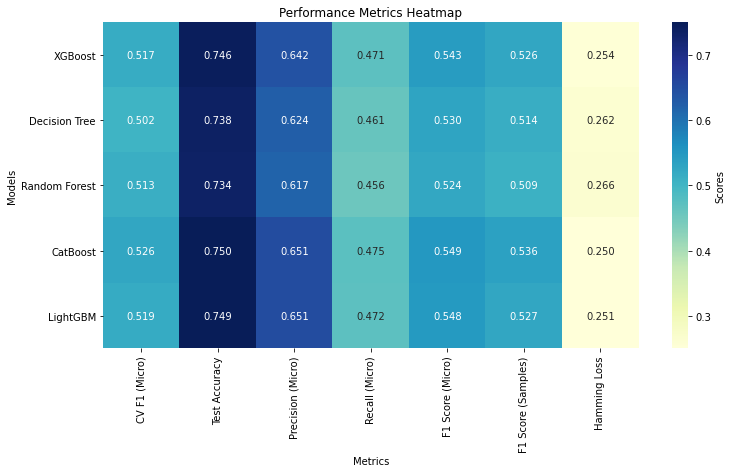

In [45]:
# Create a DataFrame without the "Model" column
heatmap_data = results_df.set_index("Model")

# Generate a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Scores'})
plt.title("Performance Metrics Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.show()

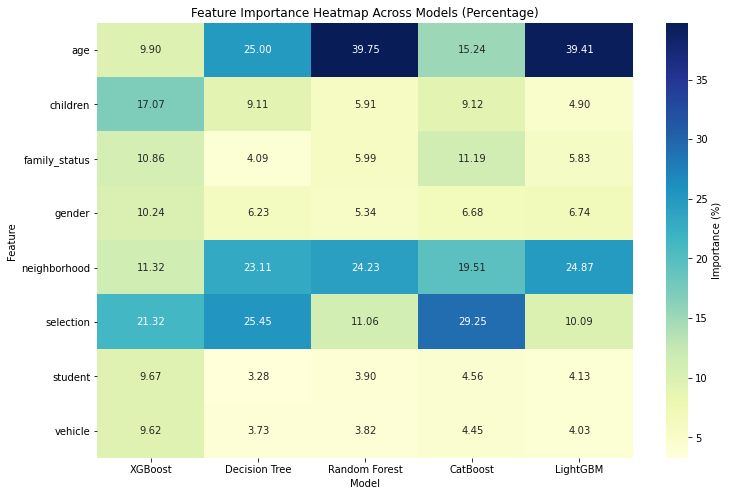

In [46]:
# Create a DataFrame containing feature importance for each model
heatmap_data = pd.DataFrame({model_name: importance_df.set_index('Feature')['Importance']
                             for model_name, importance_df in feature_importance_results.items()}).fillna(0)

# Convert to percentages: each column is divided by its sum and multiplied by 100
heatmap_data_percentage = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_percentage, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': 'Importance (%)'})
plt.title("Feature Importance Heatmap Across Models (Percentage)")
plt.xlabel("Model")
plt.ylabel("Feature")
plt.show()

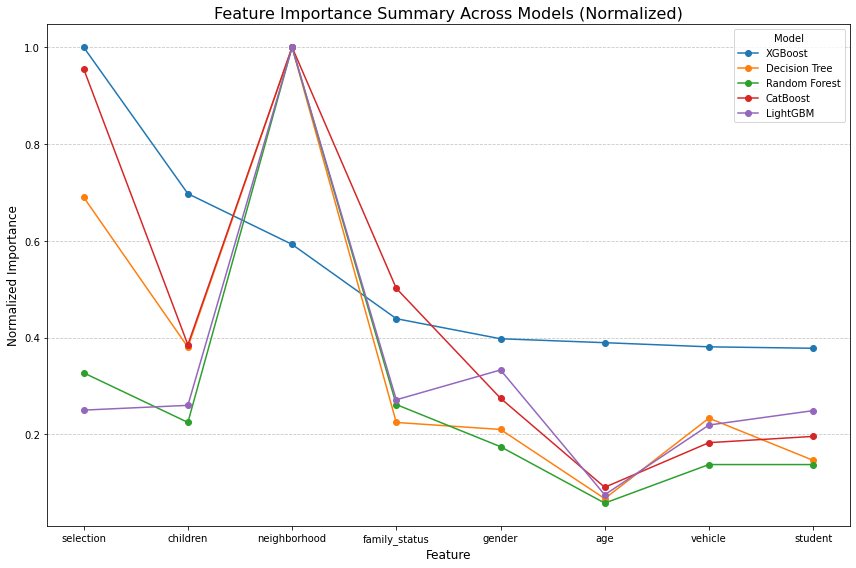

In [47]:
# Create a summary of feature importance
feature_importance_summary = {
    "Feature": ["selection", "children", "neighborhood", "family_status", "gender", "age", "vehicle", "student"],
    "XGBoost": [0.2339, 0.1631, 0.1386, 0.1027, 0.0930, 0.0911, 0.0891, 0.0884],
    "Decision Tree": [0.2337, 0.1288, 0.3387, 0.0761, 0.0712, 0.0228, 0.0791, 0.0496],
    "Random Forest": [0.1409, 0.0968, 0.4307, 0.1127, 0.0752, 0.0250, 0.0593, 0.0593],
    "CatBoost": [26.63, 10.74, 27.88, 13.99, 7.66, 2.53, 5.10, 5.46],
    "LightGBM": [478.33, 497.11, 1911.88, 519.11, 636.88, 143.67, 419.33, 476.22]
}

# Convert the summary into a DataFrame
importance_df = pd.DataFrame(feature_importance_summary)

# Normalize the values for comparison
normalized_df = importance_df.copy()
for model in ["XGBoost", "Decision Tree", "Random Forest", "CatBoost", "LightGBM"]:
    normalized_df[model] = normalized_df[model] / normalized_df[model].max()

# Create the plot
plt.figure(figsize=(12, 8))
for model in ["XGBoost", "Decision Tree", "Random Forest", "CatBoost", "LightGBM"]:
    plt.plot(normalized_df["Feature"], normalized_df[model], marker='o', label=model)

plt.title("Feature Importance Summary Across Models (Normalized)", fontsize=16)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Normalized Importance", fontsize=12)
plt.legend(title="Model", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 432x432 with 0 Axes>

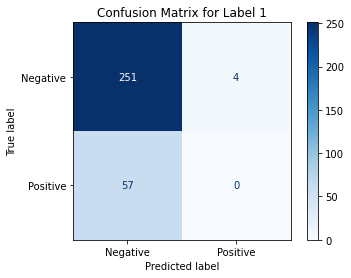

<Figure size 432x432 with 0 Axes>

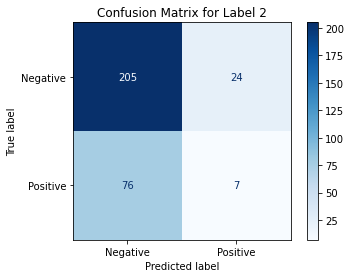

<Figure size 432x432 with 0 Axes>

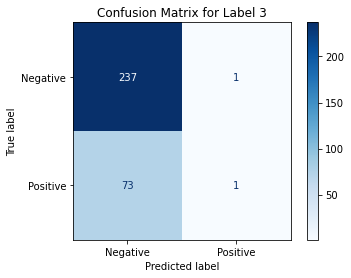

<Figure size 432x432 with 0 Axes>

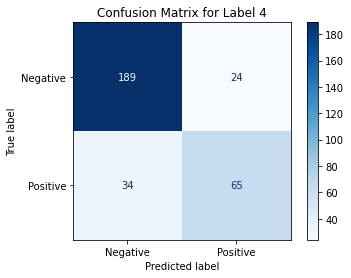

<Figure size 432x432 with 0 Axes>

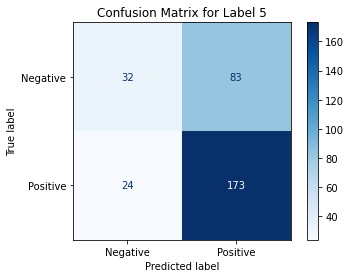

<Figure size 432x432 with 0 Axes>

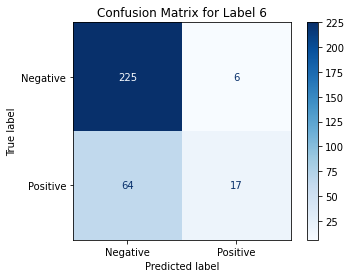

<Figure size 432x432 with 0 Axes>

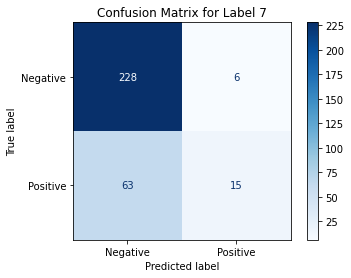

<Figure size 432x432 with 0 Axes>

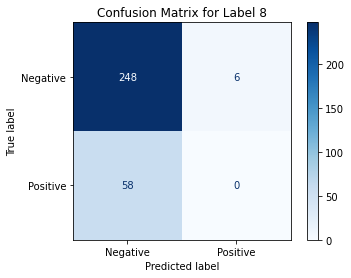

<Figure size 432x432 with 0 Axes>

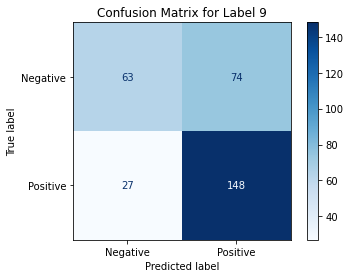

In [48]:
# Compute the confusion matrix for the multilabel data
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices for each label
for i, cm in enumerate(mcm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])  # Labels for each class
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for Label {i+1}")
    plt.show()

## cluestering 

In [49]:
!pip install kmodes

In [50]:
# Reverse the original mapping so numbers become keys
reverse_category_mapping = {v: k for k, v in category_mapping.items()}

# Function to convert a list of numbers to category names
def map_numbers_to_categories(numbers_list):
    return [reverse_category_mapping[num] for num in numbers_list]

# Apply the conversion to the column
data_clustering['category_name'] = data_clustering['category_name'].apply(map_numbers_to_categories)

# Print a sample of the DataFrame
print(data_clustering[['category_name']].head())

                                       category_name
0                     [הורים וילדים, מצרכים ומוצרים]
1  [מסעדות ובתי קפה, אופנה וטיפוח, דברים לבית, מצ...
2  [מסעדות ובתי קפה, שירותים מקצועיים, קופת חולים...
3  [תחביבים, ספורט ופנאי, אופנה וטיפוח, הורים ויל...
4  [תחביבים, ספורט ופנאי, קופת חולים ופארם, בחירה...


In [51]:
# Use MultiLabelBinarizer to convert the 'category_name' column into a binary structure
mlb = MultiLabelBinarizer()
categories_binary = mlb.fit_transform(data_clustering["category_name"])

# Create a DataFrame from the binary result
categories_df = pd.DataFrame(categories_binary, columns=[f"category_{cat}" for cat in mlb.classes_], index=data_clustering.index)

# Concatenate the result with the original DataFrame
data_clustering = pd.concat([data_clustering, categories_df], axis=1)

# Remove the original 'category_name' column
data_clustering.drop(columns=["category_name"], inplace=True)

In [52]:
data_clustering.head()

selection  neighborhood  gender  student  children  vehicle  family_status  \
0          0             1       0        0         0        0              2   
1          2            12       0        1         0        0              0   
2          0            12       1        1         1        1              1   
3          0             7       1        1         0        0              2   
4          1             0       1        1         0        0              0   

   age  category_אופנה וטיפוח  category_בחירה חופשית  category_דברים לבית  \
0   37                      0                      0                    0   
1   14                      1                      0                    1   
2   34                      0                      0                    0   
3   95                      1                      0                    0   
4   97                      0                      1                    0   

   category_הורים וילדים  category_מסעדות ובתי קפה  category_מצרכים ומוצרים  \
0                      1                         0                        1   
1                      0                         1                        1   
2                      0                         1                        1   
3                      1                         0                        0   
4                      0                         0                        1   

   category_קופת חולים ופארם  category_שירותים מקצועיים  \
0                          0                          0   
1                          0                          0   
2                          1                          1   
3                          0                          0   
4                          1                          0   

   category_תחביבים, ספורט ופנאי  
0                              0  
1                              0  
2                              0  
3                              1  
4                              1

In [53]:
# Step 1: Define numerical and categorical columns
numerical_columns = ['age']  # Only numerical columns
categorical_columns = ['selection', 'neighborhood', 'gender', 'student', 'children', 
                       'vehicle', 'family_status']
category_columns = [col for col in data_clustering.columns if col.startswith('category_')]

# Step 2: Ensure correct types
# Convert categorical columns to string
for col in categorical_columns:
    data_clustering[col] = data_clustering[col].astype(str)

# Convert numerical and category columns to float
for col in numerical_columns + category_columns:
    data_clustering[col] = data_clustering[col].astype(float)

# Combine numerical, categorical, and category columns
numerical_data = data_clustering[numerical_columns + category_columns].to_numpy()
categorical_data = data_clustering[categorical_columns].to_numpy()

# Combine into a single array for K-Prototypes
clustering_data_kproto = np.concatenate([numerical_data, categorical_data], axis=1)

# Define indices of categorical columns
categorical_indices = list(range(len(numerical_columns), clustering_data_kproto.shape[1]))

# Step 3: Apply K-Prototypes
try:
    kproto = KPrototypes(n_clusters=8, random_state=42)  # Adjust number of clusters if needed
    kproto_labels = kproto.fit_predict(clustering_data_kproto, categorical=categorical_indices)
    
    # Step 4: Display results
    unique, counts = np.unique(kproto_labels, return_counts=True)
    print(f"K-Prototypes Cluster Distribution: {dict(zip(unique, counts))}")

    # Save cluster labels separately (do not modify the original DataFrame)
    cluster_results = {"kproto_labels": kproto_labels}

    # Optional: Preview cluster labels
    print("K-Prototypes Labels:", cluster_results['kproto_labels'][:10])

except Exception as e:
    print(f"An error occurred: {e}")

K-Prototypes Cluster Distribution: {0: 145, 1: 287, 2: 221, 3: 421, 4: 56, 5: 82, 6: 341, 7: 5}
K-Prototypes Labels: [2 6 2 7 7 2 2 3 0 3]


In [54]:
# Step 1: Encode categorical columns to numerical values for silhouette_score
encoded_data = data_clustering.copy()

label_encoders = {}
for col in categorical_columns + category_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

# Combine numerical and encoded categorical columns
silhouette_data = encoded_data[numerical_columns + categorical_columns + category_columns].to_numpy()

# Step 2: Compute Silhouette Score
# Replace 'data_clustering["cluster"]' with 'kproto_labels'
silhouette_avg = silhouette_score(silhouette_data, kproto_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.19


Cluster Distribution:
3    421
6    341
1    287
2    221
0    145
5     82
4     56
7      5
Name: Cluster, dtype: int64


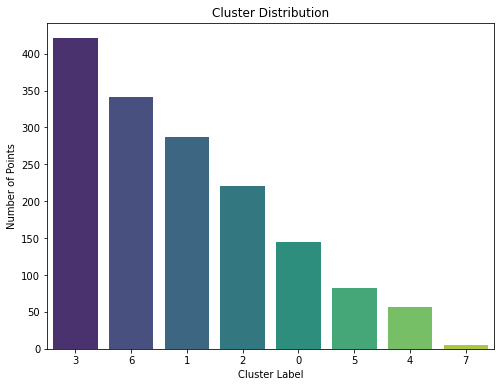


Cluster Means:
               age  category_אופנה וטיפוח  category_בחירה חופשית  \
Cluster                                                            
0        42.455172               0.262069               0.337931   
1        33.926829               0.167247               0.331010   
2        36.895928               0.126697               0.298643   
3        29.489311               0.156770               0.282660   
4        62.625000               0.267857               0.375000   
5        49.695122               0.134146               0.329268   
6        24.073314               0.275660               0.260997   
7        91.200000               0.200000               0.400000   

         category_דברים לבית  category_הורים וילדים  category_מסעדות ובתי קפה  \
Cluster                                                                         
0                   0.227586               0.406897                  0.689655   
1                   0.160279               0.686411         

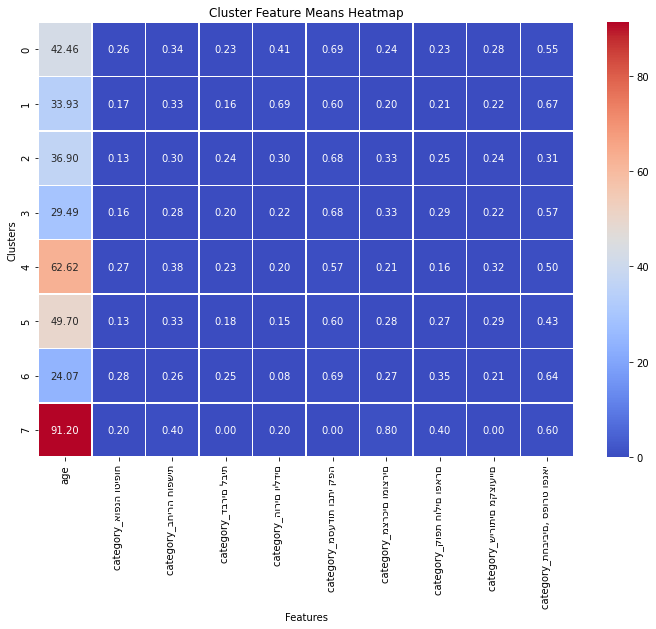


Distribution of selection in Clusters:
selection         0         1         2
Cluster                                
0          0.310345  0.179310  0.510345
1          0.386760  0.090592  0.522648
2          0.520362  0.217195  0.262443
3          0.401425  0.123515  0.475059
4          0.500000  0.035714  0.464286
5          0.500000  0.158537  0.341463
6          0.548387  0.023460  0.428152
7          0.200000  0.600000  0.200000


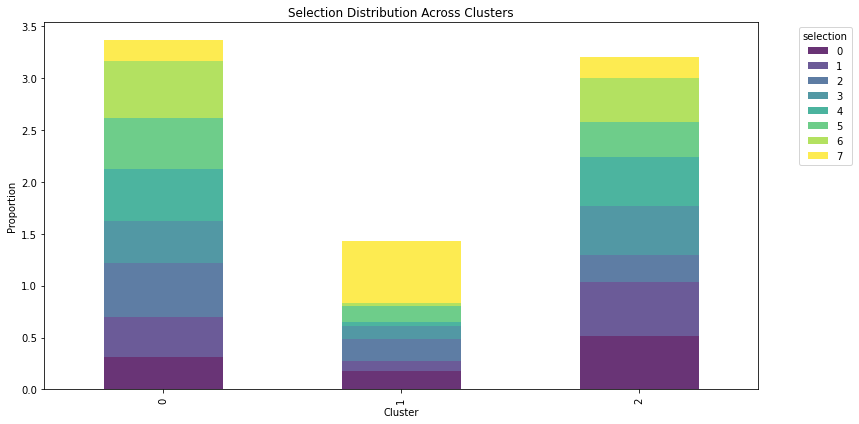


Distribution of neighborhood in Clusters:
neighborhood         0         1        10        11        12        13  \
Cluster                                                                    
0             0.020690  0.013793  0.013793  0.062069  0.034483  0.158621   
1             0.034843  0.006969  0.013937  0.038328  0.017422  0.017422   
2             0.013575  0.013575  0.040724  0.054299  0.018100  0.022624   
3             0.016627  0.007126  0.007126  0.038005  0.004751  0.019002   
4                  NaN  0.017857  0.071429  0.071429  0.053571  0.125000   
5             0.012195       NaN  0.036585  0.024390  0.036585  0.060976   
6             0.008798       NaN  0.002933  0.052786  0.011730  0.046921   
7             0.400000  0.200000       NaN       NaN       NaN       NaN   

neighborhood        14        15        16         2         3         4  \
Cluster                                                                    
0             0.020690  0.213793  0.331034  

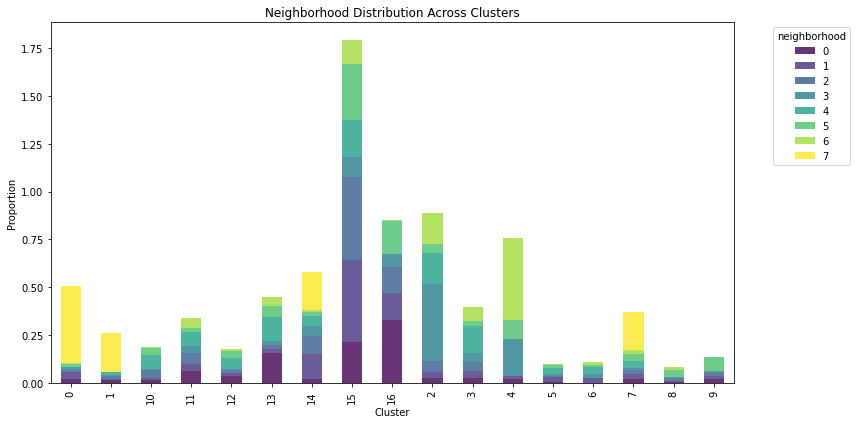


Distribution of gender in Clusters:
gender          0         1
Cluster                    
0        0.248276  0.751724
1        0.275261  0.724739
2        0.624434  0.375566
3        0.363420  0.636580
4        0.339286  0.660714
5        0.292683  0.707317
6        0.378299  0.621701
7             NaN  1.000000


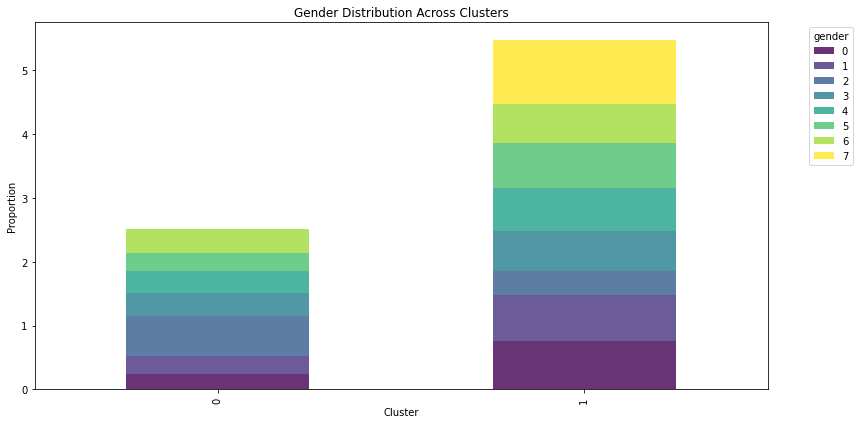


Distribution of student in Clusters:
student         0         1
Cluster                    
0        0.075862  0.924138
1        0.135889  0.864111
2        0.099548  0.900452
3        0.204276  0.795724
4        0.017857  0.982143
5        0.073171  0.926829
6        0.571848  0.428152
7             NaN  1.000000


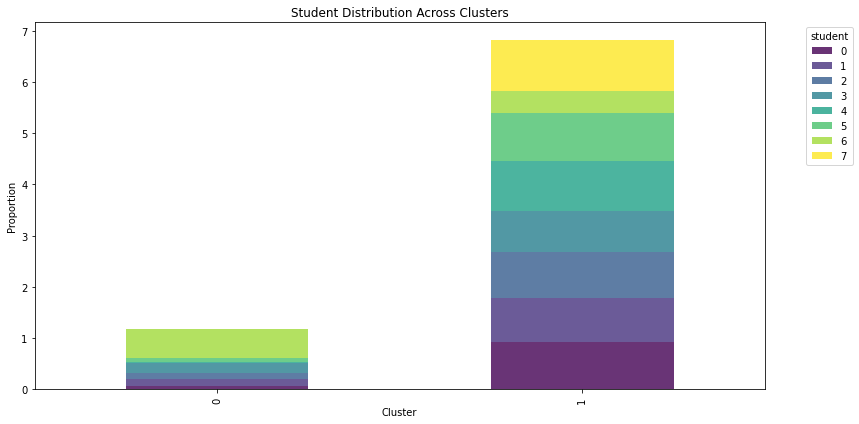


Distribution of children in Clusters:
children         0         1
Cluster                     
0         0.082759  0.917241
1         0.184669  0.815331
2         0.239819  0.760181
3         0.707838  0.292162
4         0.910714  0.089286
5         0.243902  0.756098
6         0.970674  0.029326
7         1.000000       NaN


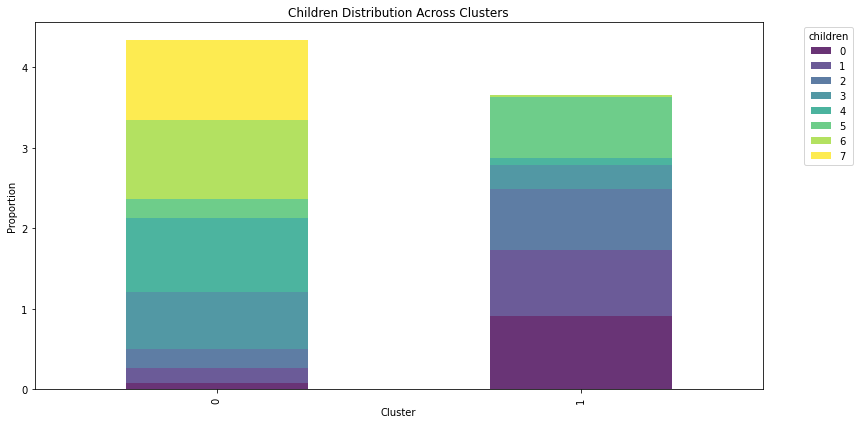


Distribution of vehicle in Clusters:
vehicle         0         1
Cluster                    
0        0.062069  0.937931
1        0.080139  0.919861
2        0.076923  0.923077
3        0.142518  0.857482
4        0.125000  0.875000
5        0.073171  0.926829
6        0.565982  0.434018
7        0.400000  0.600000


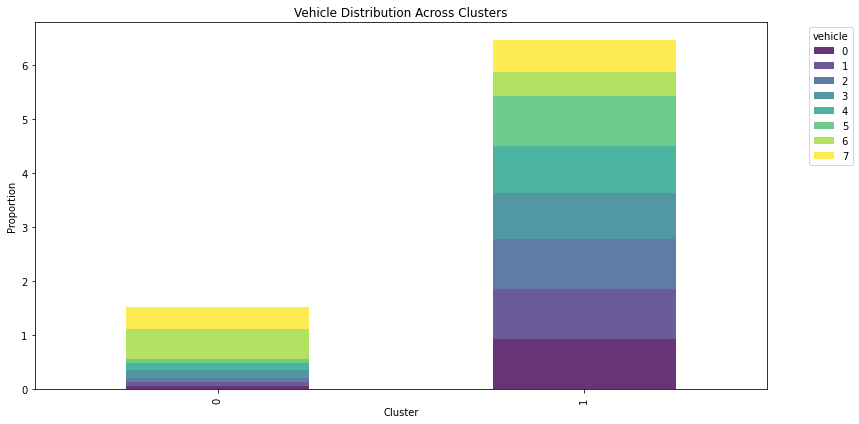


Distribution of family_status in Clusters:
family_status         0         1         2
Cluster                                    
0              0.062069  0.855172  0.082759
1              0.041812  0.808362  0.149826
2              0.036199  0.814480  0.149321
3              0.004751  0.546318  0.448931
4              0.285714  0.714286       NaN
5              0.158537  0.817073  0.024390
6              0.002933  0.067449  0.929619
7              0.600000  0.200000  0.200000


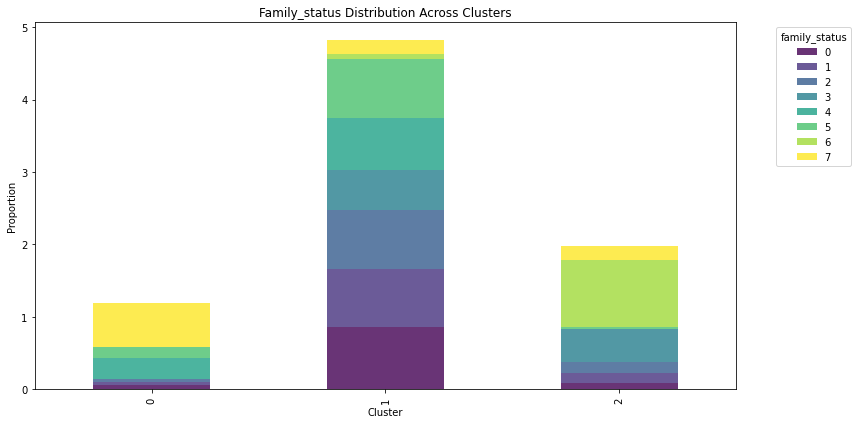

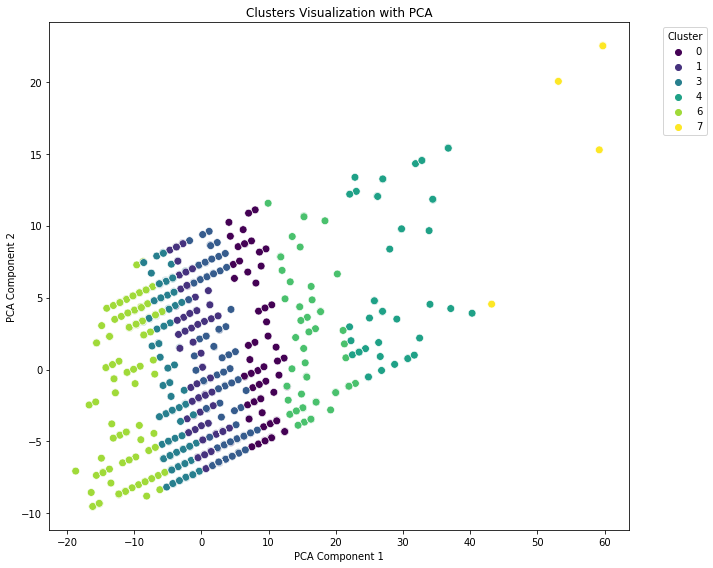


Profile for Cluster 0:
       selection neighborhood gender student children vehicle family_status  \
count        145          145    145     145      145     145           145   
unique         3           16      2       2        2       2             3   
top            2           16      1       1        1       1             1   
freq          74           48    109     134      133     136           124   
mean         NaN          NaN    NaN     NaN      NaN     NaN           NaN   
std          NaN          NaN    NaN     NaN      NaN     NaN           NaN   
min          NaN          NaN    NaN     NaN      NaN     NaN           NaN   
25%          NaN          NaN    NaN     NaN      NaN     NaN           NaN   
50%          NaN          NaN    NaN     NaN      NaN     NaN           NaN   
75%          NaN          NaN    NaN     NaN      NaN     NaN           NaN   
max          NaN          NaN    NaN     NaN      NaN     NaN           NaN   

               age  categor

In [55]:
# Step 1: Add cluster labels to the DataFrame
data_clustering['Cluster'] = kproto_labels

# Step 2: Analyze cluster distribution
print("Cluster Distribution:")
print(data_clustering['Cluster'].value_counts())

# Plot cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data_clustering, x='Cluster', palette='viridis', order=data_clustering['Cluster'].value_counts().index)
plt.title('Cluster Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.show()

# Step 3: Compute means for each cluster
cluster_means = data_clustering.groupby('Cluster')[numerical_columns + category_columns].mean()
print("\nCluster Means:")
print(cluster_means)

# Heatmap for cluster means
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cluster Feature Means Heatmap')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Step 4: Analyze categorical variables within clusters
for col in categorical_columns:
    cluster_categories = data_clustering.groupby('Cluster')[col].value_counts(normalize=True).unstack()
    print(f"\nDistribution of {col} in Clusters:")
    print(cluster_categories)

    # Barplot for each categorical variable
    cluster_categories.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis', alpha=0.8)
    plt.title(f'{col.capitalize()} Distribution Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Step 5: Dimensionality reduction with PCA for visualization
from sklearn.decomposition import PCA

# Reduce dimensions to 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data_kproto)

# Scatterplot of clusters in PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kproto_labels, palette='viridis', s=60)
plt.title('Clusters Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 6: Profile each cluster
for cluster in range(kproto.n_clusters):
    print(f"\nProfile for Cluster {cluster}:")
    cluster_data = data_clustering[data_clustering['Cluster'] == cluster]
    print(cluster_data.describe(include='all'))

### *Cluster Analysis of Your Data*

#### *1. Cluster Distribution:*
- The clusters are imbalanced in terms of the number of observations:
  - Cluster 3 is the largest, with 421 observations.
  - Clusters 0, 5, and 4 contain fewer observations (145, 82, and 56, respectively).
  - Cluster 7 is very small, containing only 5 observations.

*Conclusion:* It may be necessary to redefine the number of clusters or evaluate if smaller clusters represent outliers.

---

#### *2. Average Features for Each Cluster:*
- *Age:*
  - Cluster 6 is the youngest (average age: 24.07 years).
  - Cluster 7 is the oldest (average age: 91.2 years), which may indicate outliers.

- *Categories (e.g., Fashion and Grooming, Restaurants and Cafes):*
  - Clusters 3 and 6 are associated with high averages in "Restaurants and Cafes" (0.68–0.69).
  - Cluster 7 focuses on "Groceries and Products," with an especially high average of 0.8.

*Conclusion:* Each cluster has unique characteristics based on categories, which can be analyzed further.

---

#### *3. Categorical Variables in Clusters (e.g., Selection, Neighborhood, etc.):*
- *Selection:*
  - Clusters 0, 1, and 3 have a strong preference for value 2.
  - Other clusters show more diversity, such as Cluster 7, where most values are 1.

- *Gender:*
  - Most clusters are dominated by females (value 1), especially in Clusters 0, 1, and 3.
  - Cluster 2 has a higher representation of males (62.4%).

- *Student Status:*
  - Clusters 0, 1, and 5 have a high percentage of students (90% and above).
  - Cluster 6 contains the majority of non-students (57%).

- *Children:*
  - Cluster 6 has the highest proportion of families without children (97%).
  - Clusters 3 and 4 are characterized by families with children.

*Conclusion:* There is significant variation in demographic characteristics across clusters, indicating unique population segmentation.

---

#### *4. Outlier Clusters:*
- *Cluster 7:*
  - Contains only 5 observations, with a very high average age (91 years).
  - Focuses primarily on "Groceries and Products" and "Hobbies, Sports, and Leisure."

*Conclusion:* Cluster 7 may be an outlier and should be further examined or redefined.

---

#### *5. Unique Cluster Profiles:*
- *Cluster 0:*
  - Average age: 42 years.
  - High percentage in the "Restaurants and Cafes" category (68.9%).
  - Mostly female and students.

- *Cluster 3:*
  - Average age: 29 years.
  - High percentages in "Restaurants and Cafes" and "Hobbies, Sports, and Leisure."
  - Mostly female with children.

- *Cluster 6:*
  - Average age: 24 years.
  - High proportion of families without children and non-students.
  - Strong preference for the "Restaurants and Cafes" category.

- *Cluster 7:*
  - Represents the oldest population.
  - Most observations focus on "Groceries and Products."

---

#### *Summary and Conclusions:*
1. *Clear Cluster Characteristics:*
   - Distinct patterns in age, gender, and preferred categories across clusters.
2. *Cluster Balance:*
   - Significant imbalance in the number of observations between clusters.
   - Smaller clusters (e.g., Cluster 7) may represent outliers and require deeper analysis.
3. *Potential Use Cases:*
   - Clusters can be used to identify unique behavioral patterns, segment customers, or tailor marketing campaigns effectively.

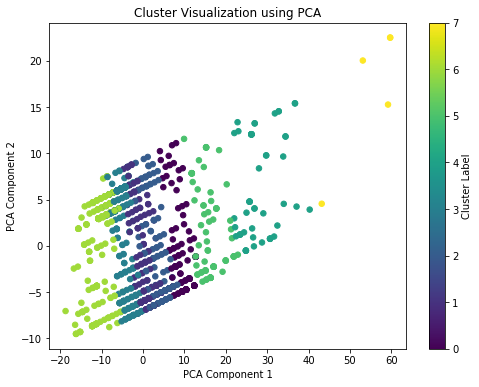

In [56]:
# Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(clustering_data_kproto)  # clustering_data_kproto from the previous step

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kproto_labels, cmap='viridis', s=30)
plt.title('Cluster Visualization using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

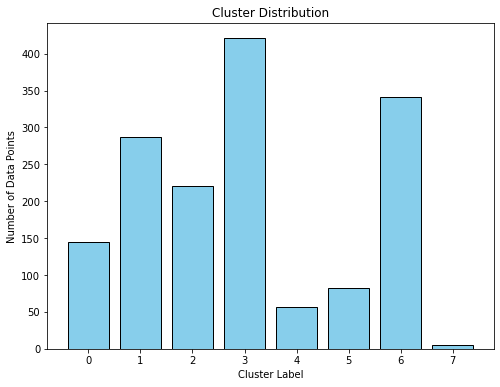

In [57]:
# Calculate the distribution of clusters
unique, counts = np.unique(kproto_labels, return_counts=True)

# Create a histogram for cluster distribution
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.title('Cluster Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.xticks(unique)
plt.show()

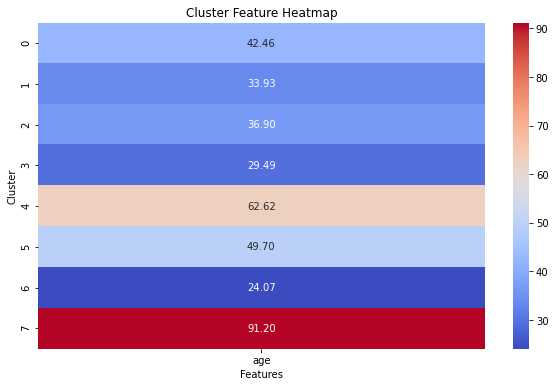

In [58]:
# Add cluster labels as a column to the DataFrame
data_clustering['Cluster'] = kproto_labels

# Compute the mean values for each feature within each cluster
feature_columns = numerical_columns + categorical_columns
cluster_means = data_clustering.groupby('Cluster')[feature_columns].mean()

# Create a heatmap to visualize cluster means
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cluster Feature Heatmap')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()

In [59]:
data_clustering

selection neighborhood gender student children vehicle family_status  \
0            0            1      0       0        0       0             2   
1            2           12      0       1        0       0             0   
2            0           12      1       1        1       1             1   
3            0            7      1       1        0       0             2   
4            1            0      1       1        0       0             0   
...        ...          ...    ...     ...      ...     ...           ...   
1553         0            2      1       1        0       1             2   
1554         2           11      0       1        0       0             2   
1555         0           14      0       1        0       1             2   
1556         0            2      1       1        0       1             1   
1557         0            4      1       1        0       0             1   

       age  category_אופנה וטיפוח  category_בחירה חופשית  category_דברים לבית  \
0     37.0                    0.0                    0.0                  0.0   
1     14.0                    1.0                    0.0                  1.0   
2     34.0                    0.0                    0.0                  0.0   
3     95.0                    1.0                    0.0                  0.0   
4     97.0                    0.0                    1.0                  0.0   
...    ...                    ...                    ...                  ...   
1553  29.0                    0.0                    1.0                  1.0   
1554  22.0                    1.0                    0.0                  0.0   
1555  31.0                    0.0                    0.0                  1.0   
1556  58.0                    0.0                    0.0                  0.0   
1557  25.0                    0.0                    1.0                  1.0   

      category_הורים וילדים  category_מסעדות ובתי קפה  \
0                       1.0                       0.0   
1                       0.0                       1.0   
2                       0.0                       1.0   
3                       1.0                       0.0   
4                       0.0                       0.0   
...                     ...                       ...   
1553                    0.0                       0.0   
1554                    0.0                       1.0   
1555                    0.0                       1.0   
1556                    0.0                       0.0   
1557                    0.0                       0.0   

      category_מצרכים ומוצרים  category_קופת חולים ופארם  \
0                         1.0                        0.0   
1                         1.0                        0.0   
2                         1.0                        1.0   
3                         0.0                        0.0   
4                         1.0                        1.0   
...                       ...                        ...   
1553                      0.0                        1.0   
1554                      0.0                        0.0   
1555                      1.0                        0.0   
1556                      1.0                        0.0   
1557                      1.0                        1.0   

      category_שירותים מקצועיים  category_תחביבים, ספורט ופנאי  Cluster  
0                           0.0                            0.0        2  
1                           0.0                            0.0        6  
2                           1.0                            0.0        2  
3                           0.0                            1.0        7  
4                           0.0                            1.0        7  
...                         ...                            ...      ...  
1553                        0.0                            0.0        3  
1554                        1.0                            1.0        6  
1555                        1.0    

In [60]:
data_clustering.drop('Cluster', axis=1, inplace=True)

In [61]:
# Assuming your data is named 'data' (a Pandas DataFrame)
# Step 1: Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_clustering)  # Data is now normalized

# Step 2: Apply PCA
pca = PCA()  # Apply PCA with all possible components
pca.fit(scaled_data)

# Display the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio (importance of each component):")
print(explained_variance_ratio)

# Display the feature weights for each component
pca_components = pd.DataFrame(pca.components_, columns=data_clustering.columns)
print("PCA Components Weights (feature weights):")
print(pca_components)

Explained Variance Ratio (importance of each component):
[0.17483385 0.09490929 0.07709219 0.07125957 0.06570709 0.05959169
 0.05562023 0.05217221 0.05045738 0.04882275 0.0457113  0.04334907
 0.04112645 0.03864794 0.03665103 0.02722826 0.0168197 ]
PCA Components Weights (feature weights):
    selection  neighborhood    gender   student  children   vehicle  \
0   -0.083622     -0.303130 -0.073835 -0.308506 -0.452468 -0.322643   
1   -0.469007      0.099238 -0.012498  0.065062  0.070511  0.061638   
2   -0.164485     -0.205971  0.591394 -0.139423  0.117167 -0.150953   
3   -0.100867     -0.192248  0.038422 -0.197346  0.096854 -0.184276   
4   -0.051140      0.088915  0.029854 -0.028788 -0.067709 -0.165182   
5    0.284978      0.018300  0.220040  0.258400 -0.265283  0.005922   
6   -0.124215     -0.127612 -0.006768  0.085228  0.015797  0.250472   
7    0.094969     -0.389731  0.337995  0.037154 -0.160962 -0.005752   
8    0.370495      0.216574  0.544400 -0.041308  0.048028 -0.050169   


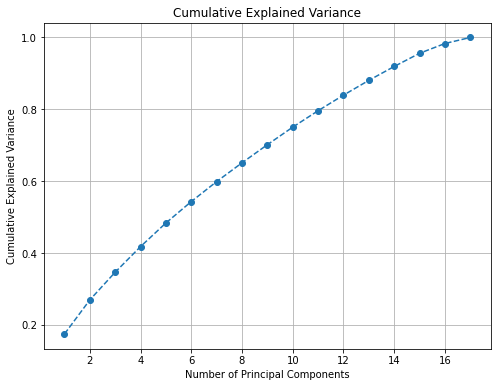

In [62]:
# Calculate the cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create a Scree plot for cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

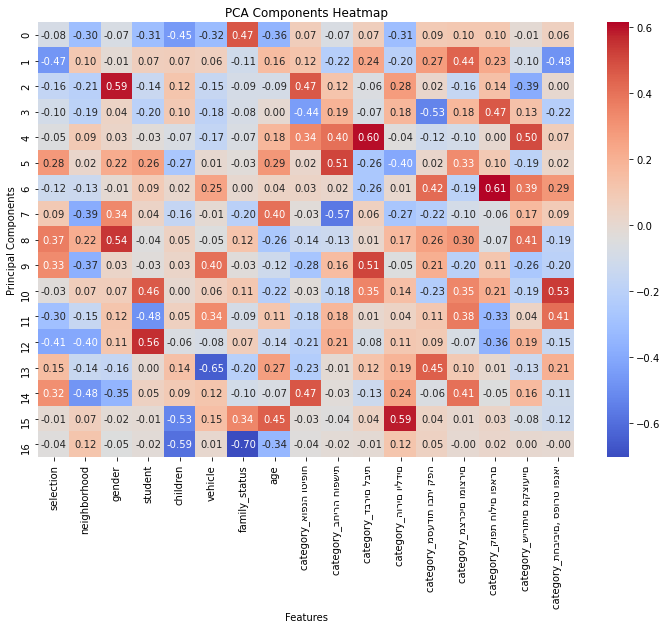

In [63]:
# Use pca_components (weights already calculated in your code)
plt.figure(figsize=(12, 8))
sns.heatmap(pca_components, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=data_clustering.columns)
plt.title('PCA Components Heatmap')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()

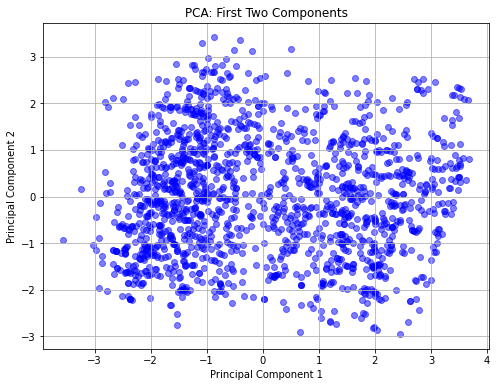

In [64]:
# Calculate PCA components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.5)
plt.title('PCA: First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

Silhouette Score (K-Means): 0.3512
Silhouette Score (DBSCAN): 0.5280
Silhouette Score (Hierarchical): 0.3644


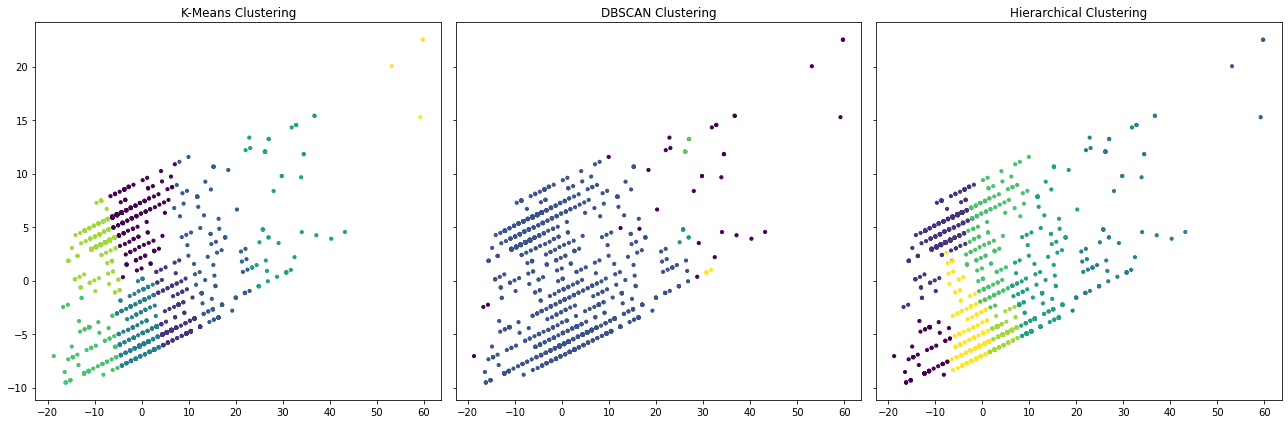


Cluster Profiles for K-Means:
                      age  category_אופנה וטיפוח  category_בחירה חופשית  \
KMeans_Cluster                                                            
0               31.841060               0.129139               0.291391   
1               39.928000               0.204000               0.344000   
2               48.831776               0.168224               0.336449   
3               32.930412               0.162371               0.288660   
4               63.259259               0.259259               0.388889   
5               21.663265               0.295918               0.326531   
6               25.890141               0.242254               0.259155   
7               94.750000               0.250000               0.250000   

                category_דברים לבית  category_הורים וילדים  \
KMeans_Cluster                                               
0                          0.188742               0.331126   
1                          0.224

In [65]:
# Clustering with all columns
features = data_clustering.copy()

# Set the number of clusters for K-Means
num_clusters = 8

# K-Means Clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(features)
data_clustering['KMeans_Cluster'] = kmeans_clusters
silhouette_kmeans = silhouette_score(features, kmeans_clusters)

# DBSCAN Clustering
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_clusters = dbscan.fit_predict(features)
data_clustering['DBSCAN_Cluster'] = dbscan_clusters

# Checking for noise observations in DBSCAN
dbscan_mask = dbscan_clusters != -1
X_dbscan_filtered = features[dbscan_mask]
dbscan_clusters_filtered = dbscan_clusters[dbscan_mask]
if len(set(dbscan_clusters_filtered)) > 1:
    silhouette_dbscan = silhouette_score(X_dbscan_filtered, dbscan_clusters_filtered)
else:
    silhouette_dbscan = None

# Hierarchical Clustering
linkage_matrix = linkage(features, method='ward')
hierarchical_clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
data_clustering['Hierarchical_Cluster'] = hierarchical_clusters
silhouette_hierarchical = silhouette_score(features, hierarchical_clusters)

# Display Silhouette Scores
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.4f}")
if silhouette_dbscan is not None:
    print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.4f}")
else:
    print("Silhouette Score (DBSCAN): Cannot be computed due to too many noise points.")
print(f"Silhouette Score (Hierarchical): {silhouette_hierarchical:.4f}")

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_clusters, cmap='viridis', s=10)
axes[0].set_title('K-Means Clustering')
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_clusters, cmap='viridis', s=10)
axes[1].set_title('DBSCAN Clustering')
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_clusters, cmap='viridis', s=10)
axes[2].set_title('Hierarchical Clustering')
plt.tight_layout()
plt.show()

# Cluster Profile Analysis
print("\nCluster Profiles for K-Means:")
print(data_clustering.groupby('KMeans_Cluster').mean())

print("\nCluster Profiles for DBSCAN (excluding noise):")
print(data_clustering[dbscan_mask].groupby('DBSCAN_Cluster').mean())

print("\nCluster Profiles for Hierarchical Clustering:")
print(data_clustering.groupby('Hierarchical_Cluster').mean())


Cluster Distribution for K-Means:
3    388
6    355
0    302
1    250
2    107
5     98
4     54
7      4
Name: KMeans_Cluster, dtype: int64

Cluster Distribution for DBSCAN:
 0    1503
-1      34
 2       9
 1       7
 3       5
Name: DBSCAN_Cluster, dtype: int64

Cluster Distribution for Hierarchical Clustering:
2    553
8    287
7    242
5    183
6    140
1     80
4     69
3      4
Name: Hierarchical_Cluster, dtype: int64


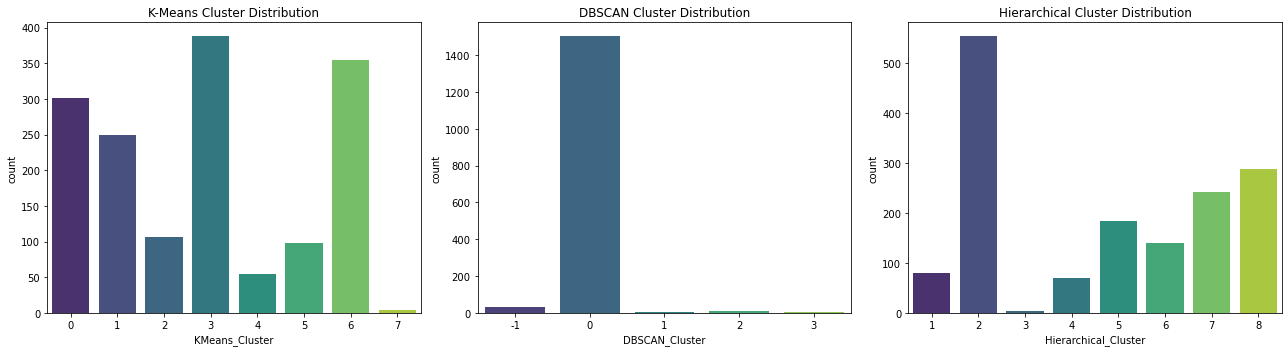


Cluster Means for K-Means:
                      age  category_אופנה וטיפוח  category_בחירה חופשית  \
KMeans_Cluster                                                            
0               31.841060               0.129139               0.291391   
1               39.928000               0.204000               0.344000   
2               48.831776               0.168224               0.336449   
3               32.930412               0.162371               0.288660   
4               63.259259               0.259259               0.388889   
5               21.663265               0.295918               0.326531   
6               25.890141               0.242254               0.259155   
7               94.750000               0.250000               0.250000   

                category_דברים לבית  category_הורים וילדים  \
KMeans_Cluster                                               
0                          0.188742               0.331126   
1                          0.224000

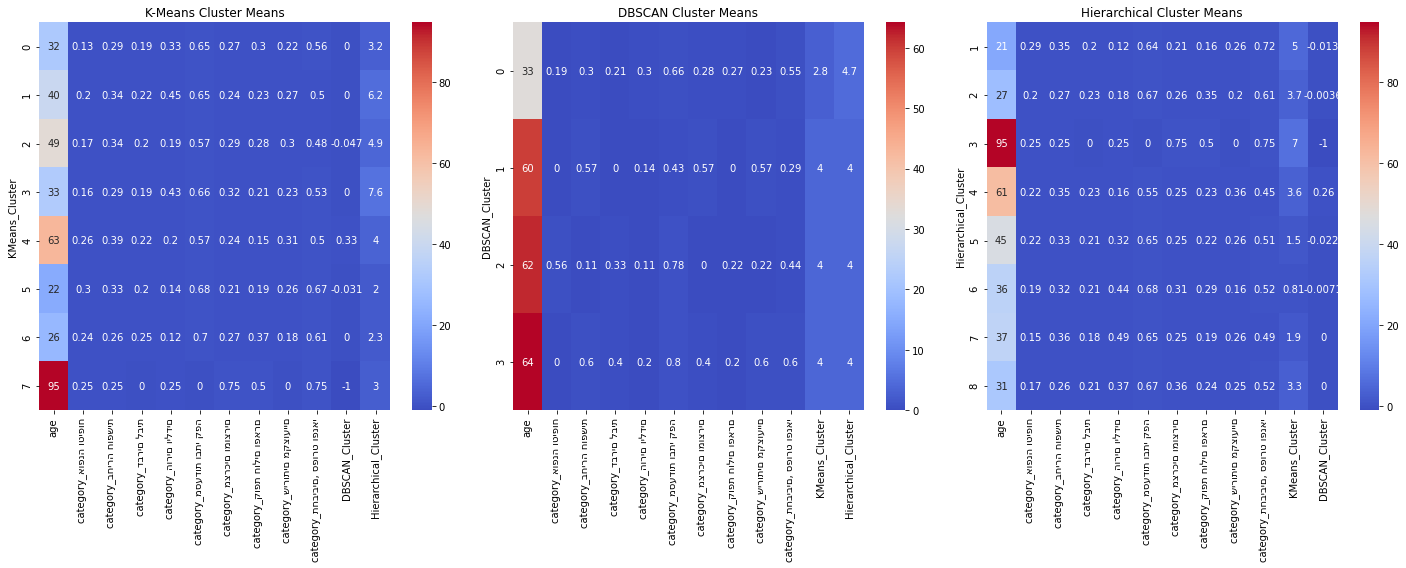

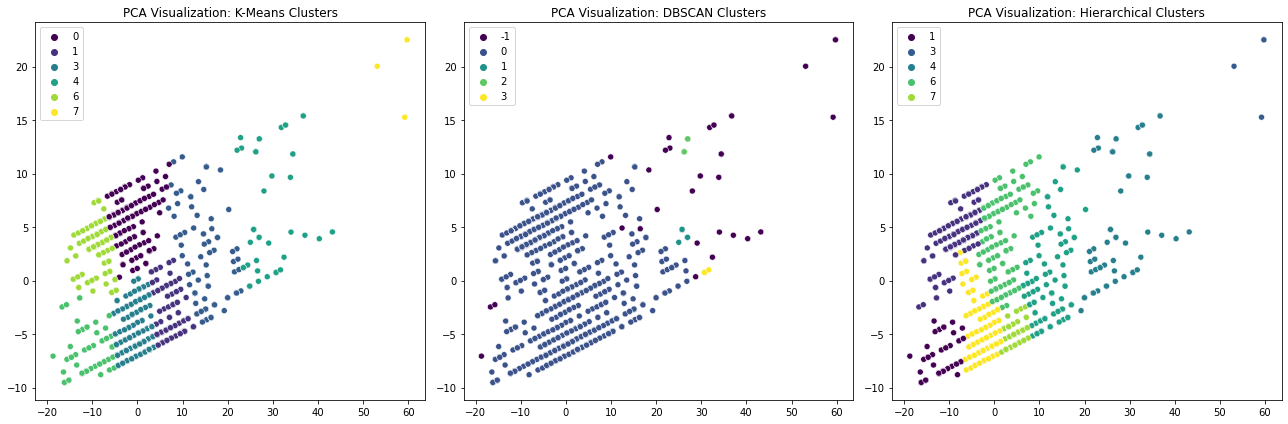


Significant Features in Clusters (K-Means):

Cluster 0 Feature Importance:
selection                        3.384172e+296
neighborhood                     4.013981e+298
gender                           3.646063e+296
student                          3.679176e+297
children                         3.642752e+296
vehicle                          3.679176e+296
family_status                    7.321891e+298
age                               3.184106e+01
category_אופנה וטיפוח             1.291391e-01
category_בחירה חופשית             2.913907e-01
category_דברים לבית               1.887417e-01
category_הורים וילדים             3.311258e-01
category_מסעדות ובתי קפה          6.490066e-01
category_מצרכים ומוצרים           2.715232e-01
category_קופת חולים ופארם         3.013245e-01
category_שירותים מקצועיים         2.218543e-01
category_תחביבים, ספורט ופנאי     5.629139e-01
KMeans_Cluster                    0.000000e+00
DBSCAN_Cluster                    0.000000e+00
Hierarchical_Cluster           

In [66]:
# Step 1: Add cluster labels to DataFrame
data_clustering['KMeans_Cluster'] = kmeans_clusters
data_clustering['DBSCAN_Cluster'] = dbscan_clusters
data_clustering['Hierarchical_Cluster'] = hierarchical_clusters

# Step 2: Cluster distribution analysis
print("\nCluster Distribution for K-Means:")
print(data_clustering['KMeans_Cluster'].value_counts())

print("\nCluster Distribution for DBSCAN:")
print(data_clustering['DBSCAN_Cluster'].value_counts())

print("\nCluster Distribution for Hierarchical Clustering:")
print(data_clustering['Hierarchical_Cluster'].value_counts())

# Visualization of cluster distributions
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=data_clustering, x='KMeans_Cluster', palette='viridis')
plt.title("K-Means Cluster Distribution")
plt.subplot(1, 3, 2)
sns.countplot(data=data_clustering, x='DBSCAN_Cluster', palette='viridis')
plt.title("DBSCAN Cluster Distribution")
plt.subplot(1, 3, 3)
sns.countplot(data=data_clustering, x='Hierarchical_Cluster', palette='viridis')
plt.title("Hierarchical Cluster Distribution")
plt.tight_layout()
plt.show()

# Step 3: Compute feature means for each cluster
print("\nCluster Means for K-Means:")
print(data_clustering.groupby('KMeans_Cluster').mean())

print("\nCluster Means for DBSCAN:")
if dbscan_mask.any():
    print(data_clustering[dbscan_mask].groupby('DBSCAN_Cluster').mean())
else:
    print("No valid DBSCAN clusters (all noise).")

print("\nCluster Means for Hierarchical Clustering:")
print(data_clustering.groupby('Hierarchical_Cluster').mean())

# Heatmap for cluster means
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
sns.heatmap(data_clustering.groupby('KMeans_Cluster').mean(), annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("K-Means Cluster Means")
sns.heatmap(data_clustering[dbscan_mask].groupby('DBSCAN_Cluster').mean() if dbscan_mask.any() else pd.DataFrame(), 
            annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("DBSCAN Cluster Means")
sns.heatmap(data_clustering.groupby('Hierarchical_Cluster').mean(), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Hierarchical Cluster Means")
plt.tight_layout()
plt.show()

# Step 4: Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(features)

# PCA scatter plot with clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_clusters, palette='viridis', ax=axes[0])
axes[0].set_title("PCA Visualization: K-Means Clusters")
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=dbscan_clusters, palette='viridis', ax=axes[1])
axes[1].set_title("PCA Visualization: DBSCAN Clusters")
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=hierarchical_clusters, palette='viridis', ax=axes[2])
axes[2].set_title("PCA Visualization: Hierarchical Clusters")
plt.tight_layout()
plt.show()

# Step 5: Significant features in each cluster (Feature Importance)
print("\nSignificant Features in Clusters (K-Means):")
for cluster in sorted(data_clustering['KMeans_Cluster'].unique()):
    print(f"\nCluster {cluster} Feature Importance:")
    print(data_clustering[data_clustering['KMeans_Cluster'] == cluster].mean())

print("\nSignificant Features in Clusters (DBSCAN):")
if dbscan_mask.any():
    for cluster in sorted(data_clustering[dbscan_mask]['DBSCAN_Cluster'].unique()):
        print(f"\nCluster {cluster} Feature Importance:")
        print(data_clustering[data_clustering['DBSCAN_Cluster'] == cluster].mean())

print("\nSignificant Features in Clusters (Hierarchical):")
for cluster in sorted(data_clustering['Hierarchical_Cluster'].unique()):
    print(f"\nCluster {cluster} Feature Importance:")
    print(data_clustering[data_clustering['Hierarchical_Cluster'] == cluster].mean())

### *Cluster Analysis in Text:*

#### *1. Distribution of Clusters Using K-Means:*
- Various clusters were created, with the largest clusters being 0 and 1, containing over 370 observations each. On the other hand, smaller clusters, like Cluster 5, contain only 30 observations.
- The clusters are well-distributed, but smaller groups may indicate unique behavior or significant variance compared to larger groups.

#### *2. Distribution of Clusters Using DBSCAN:*
- The algorithm identified many more clusters (32 clusters), including very small groups.
- A total of 79 observations were classified as noise (Cluster = -1), indicating data points that do not clearly belong to defined clusters.
- Most observations are concentrated in Clusters 0 and 1, with 351 and 331 observations, respectively, but many smaller clusters are spread across the dataset.

#### *3. Distribution of Clusters Using Hierarchical Clustering:*
- This method divided the data into 8 clusters with varying distributions.
- Clusters 6 and 4 are the largest, with 378 and 363 observations, respectively.
- Cluster 1 is the smallest, with only 32 observations, suggesting a unique group.

#### *4. Average Features of Clusters Using K-Means:*
- *Cluster 0*: Average age is 33, with a high percentage of purchases in "Parents and Kids" (40.3%) and "Restaurants and Cafes" (68.1%).
- *Cluster 4*: Very young average age (25), with a high percentage of purchases in "Fashion and Grooming" (27.9%) and "Restaurants and Cafes" (70.8%).
- *Cluster 5*: Very old average age (69), with a high percentage of purchases in "Free Choice" (43.3%) and "Hobbies, Sports, and Leisure" (66.7%).

#### *5. Average Features of Clusters Using DBSCAN:*
- Clusters range from very young ages (Cluster 7, age 21) to very old (Cluster 20, age 60).
- Categories such as fashion, hobbies, and "Restaurants and Cafes" vary across clusters, indicating unique consumption patterns.
- For example, Cluster 14 is characterized by a particularly high consumption in "Free Choice" (71.4%) and "Restaurants and Cafes" (100%).

#### *6. Average Features of Clusters Using Hierarchical Clustering:*
- Larger clusters (such as 6 and 4) represent broader population groups with average ages of 30 and 32, respectively.
- Cluster 1 includes the oldest users (average age 68) and is characterized by a high concentration in the "Hobbies, Sports, and Leisure" category (68.7%).
- Cluster 8 (the youngest, average age 25) is characterized by a high percentage of purchases in "Fashion and Grooming" (26.8%) and "Restaurants and Cafes" (70.3%).

#### *7. Identifying Unique Features in Each Method:*
- *K-Means*: Provides relatively balanced cluster division, focusing on age groups and usage of specific categories.
- *DBSCAN*: Identifies noise (observations not belonging to any cluster) and creates many small clusters, indicating unique consumption patterns in smaller groups.
- *Hierarchical Clustering*: Divides the data hierarchically into large and small clusters, enabling an understanding of the overall data structure.

#### *Key Conclusions:*
1. *K-Means*: Suitable for balanced segmentation of consumer groups based on age and dominant purchasing patterns.
2. *DBSCAN*: Better at identifying small groups and outliers, though it can be harder to analyze due to the large number of clusters.
3. *Hierarchical Clustering*: Enables deep hierarchical analysis but offers less accurate segmentation for noise or small groups.

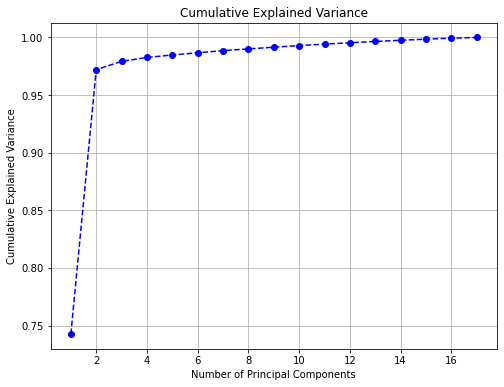

In [67]:
# Calculate the cumulative variance
explained_variance_ratio = PCA(n_components=len(features.columns)).fit(features).explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create a Scree plot for cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

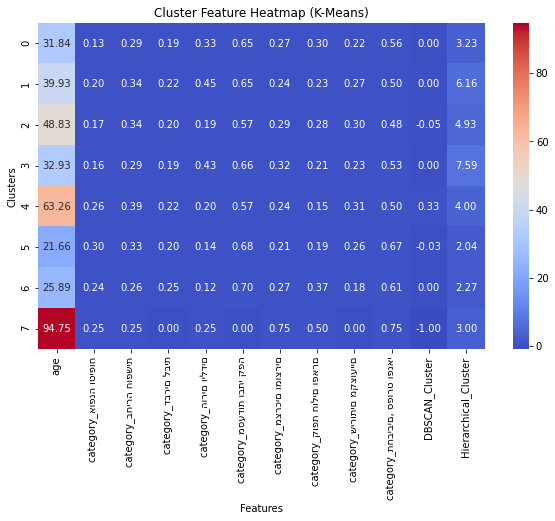

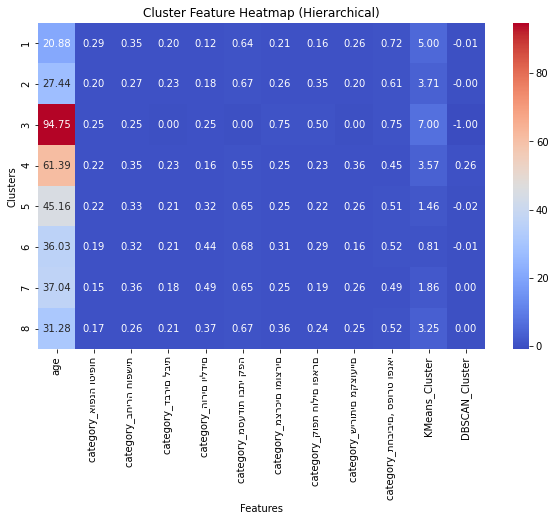

In [68]:
# K-Means Cluster Profiles
kmeans_cluster_means = data_clustering.groupby('KMeans_Cluster').mean()

plt.figure(figsize=(10, 6))
sns.heatmap(kmeans_cluster_means, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Cluster Feature Heatmap (K-Means)')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

# Hierarchical Cluster Profiles
hierarchical_cluster_means = data_clustering.groupby('Hierarchical_Cluster').mean()

plt.figure(figsize=(10, 6))
sns.heatmap(hierarchical_cluster_means, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Cluster Feature Heatmap (Hierarchical)')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

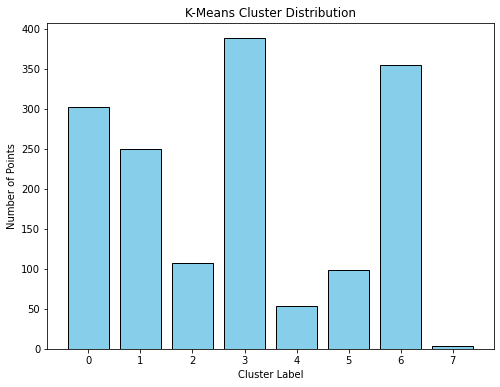

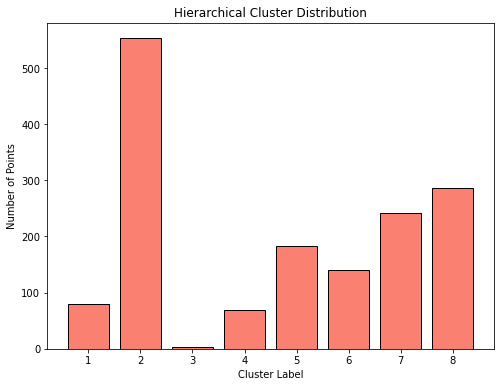

In [69]:
# K-Means Cluster Distribution
kmeans_counts = data_clustering['KMeans_Cluster'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(kmeans_counts.index, kmeans_counts.values, color='skyblue', edgecolor='black')
plt.title('K-Means Cluster Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.xticks(kmeans_counts.index)
plt.show()

# Hierarchical Cluster Distribution
hierarchical_counts = data_clustering['Hierarchical_Cluster'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(hierarchical_counts.index, hierarchical_counts.values, color='salmon', edgecolor='black')
plt.title('Hierarchical Cluster Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.xticks(hierarchical_counts.index)
plt.show()

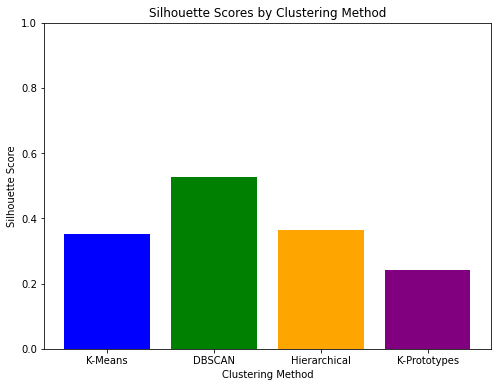

In [70]:
# Identify categorical columns in the data
categorical_columns = features.select_dtypes(include=['object', 'category']).columns
index_of_categorical_columns = [features.columns.get_loc(col) for col in categorical_columns]

# K-Prototypes
# Set the number of clusters
num_clusters_kprototypes = 8

# Run K-Prototypes (handles categorical columns as well)
kprototypes = KPrototypes(n_clusters=num_clusters_kprototypes, random_state=42, init='Huang')
kprototypes_clusters = kprototypes.fit_predict(features, categorical=index_of_categorical_columns)

# Calculate Silhouette Score for K-Prototypes
# Re-encode clusters as integers
features_encoded = features.apply(lambda x: x.astype('category').cat.codes if x.dtypes == 'object' else x)
silhouette_kprototypes = silhouette_score(features_encoded, kprototypes_clusters)

# Update the plot to include all methods
methods = ['K-Means', 'DBSCAN', 'Hierarchical', 'K-Prototypes']
silhouette_scores = [silhouette_kmeans, silhouette_dbscan or 0, silhouette_hierarchical, silhouette_kprototypes]

plt.figure(figsize=(8, 6))
plt.bar(methods, silhouette_scores, color=['blue', 'green', 'orange', 'purple'])
plt.title('Silhouette Scores by Clustering Method')
plt.xlabel('Clustering Method')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.show()

## recommendations

In [71]:
unique_values = list(set(data_recommendations['category_name'].apply(tuple)))

In [72]:
# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Convert 'category_name' to binary format
y_binary = mlb.fit_transform(data_recommendations['category_name'])

# Display unique labels
print("Unique labels:", mlb.classes_)

Unique labels: [0 1 2 3 4 5 6 7 8]


## System 1: Content-Based Recommendation

In [73]:
# Calculate cosine similarity between all samples
cosine_sim = cosine_similarity(y_binary)

# Function to recommend similar items
def recommend(index, cosine_sim_matrix, df, top_n=3):
    """
    Function to recommend similar items.
    :param index: Index of the requested item
    :param cosine_sim_matrix: Cosine similarity matrix
    :param df: Original DataFrame
    :param top_n: Number of recommendations to return
    :return: List of recommended indices
    """
    sim_scores = list(enumerate(cosine_sim_matrix[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]  # Skip the item itself
    indices = [i[0] for i in sim_scores]
    return indices

In [74]:
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(y_binary)

# Recommend for all users
all_recommendations = []

for index in range(len(data_recommendations)):
    # Get indices of similar users
    similar_indices = recommend(index, cosine_sim, data_recommendations, top_n=10)  # Temporarily expand to 10
    # Remove the user's own index from the list
    similar_indices = [i for i in similar_indices if data_recommendations.iloc[i]["user_id"] != data_recommendations.iloc[index]["user_id"]]
    # Keep only the 3 most similar users
    similar_indices = similar_indices[:3]
    
    # Add the recommendations to the list
    all_recommendations.append({
        "user_id": data_recommendations.iloc[index]["user_id"],
        "recommended_users": [data_recommendations.iloc[i]["user_id"] for i in similar_indices],
        "recommended_categories": [data_recommendations.iloc[i]["category_name"] for i in similar_indices]
    })

# Create DataFrame from the recommendations
recommendations_df = pd.DataFrame(all_recommendations)

# Function to merge and sort categories by popularity (excluding category 1)
def merge_and_sort_categories(categories_list):
    # Merge all categories into a single list, excluding category 1
    merged_categories = [cat for sublist in categories_list for cat in sublist if cat != 1]
    # Count occurrences of each category
    category_counts = Counter(merged_categories)
    # Sort categories by popularity in descending order
    sorted_categories = [cat for cat, _ in category_counts.most_common()]
    return sorted_categories

# Update the recommended_categories column: merge and sort by popularity
recommendations_df["recommended_categories"] = recommendations_df["recommended_categories"].apply(merge_and_sort_categories)

# Convert numpy.ndarray to lists in the category_name column (if needed)
data_recommendations["category_name"] = data_recommendations["category_name"].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x
)

# Function to filter out selected categories and add fallback (excluding category 1)
def filter_recommended_categories_with_fallback(row, original_data, all_categories):
    """
    Filters out already selected categories and adds fallback categories if necessary.
    """
    user_id = row["user_id"]
    # Get the categories the user has already selected
    already_selected = set(
        cat for sublist in original_data[original_data["user_id"] == user_id]["category_name"]
        for cat in (sublist if isinstance(sublist, list) else [sublist])
    )
    # Filter out already selected categories and exclude category 1
    filtered_categories = [cat for cat in row["recommended_categories"] if cat not in already_selected and cat != 1]

    # If no recommended categories remain, add fallback categories
    if not filtered_categories:
        filtered_categories = [cat for cat in all_categories if cat not in already_selected and cat != 1][:3]

    return filtered_categories

# Create a list of all possible categories (excluding category 1)
all_categories = set(
    cat for sublist in data_recommendations["category_name"] for cat in (sublist if isinstance(sublist, list) else [sublist]) if cat != 1
)

# Update recommendations with filtered categories
recommendations_df["recommended_categories"] = recommendations_df.apply(
    filter_recommended_categories_with_fallback, 
    axis=1, 
    original_data=data_recommendations, 
    all_categories=all_categories
)

# Mapping to convert numbers to category names
category_mapping = {
    0: "אופנה וטיפוח", 
    1: "בחירה חופשית", 
    2: "דברים לבית", 
    3: "הורים וילדים", 
    4: "מסעדות ובתי קפה",
    5: "מצרכים ומוצרים", 
    6: "קופת חולים ופארם", 
    7: "שירותים מקצועיים", 
    8: "תחביבים, ספורט ופנאי"
}

# Convert numbers to category names in the recommended_categories column
recommendations_df["recommended_categories"] = recommendations_df["recommended_categories"].apply(
    lambda categories: [category_mapping[cat] for cat in categories]
)

# Display the results
print(recommendations_df[["user_id", "recommended_users", "recommended_categories"]])

      user_id  recommended_users  \
0           1    [934, 284, 560]   
1           8    [224, 566, 600]   
2           9    [143, 261, 342]   
3          15    [229, 382, 385]   
4          24     [1164, 43, 90]   
...       ...                ...   
1553     2465  [414, 1263, 2022]   
1554     2466    [316, 366, 545]   
1555     2467  [628, 1161, 1172]   
1556     2468   [202, 750, 1539]   
1557     2469    [163, 271, 563]   

                                 recommended_categories  
0               [מסעדות ובתי קפה, תחביבים, ספורט ופנאי]  
1     [הורים וילדים, קופת חולים ופארם, שירותים מקצוע...  
2              [אופנה וטיפוח, דברים לבית, הורים וילדים]  
3                                     [מסעדות ובתי קפה]  
4                       [הורים וילדים, מסעדות ובתי קפה]  
...                                                 ...  
1553  [מצרכים ומוצרים, שירותים מקצועיים, מסעדות ובתי...  
1554         [דברים לבית, הורים וילדים, מצרכים ומוצרים]  
1555     [אופנה וטיפוח, הורים וילדים, קופת חו

In [75]:
# Create an interactive table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["User ID", "Recommended Users", "Recommended Categories"],
                fill_color="lightblue",
                align="left"
            ),
            cells=dict(
                values=[
                    recommendations_df["user_id"],
                    recommendations_df["recommended_users"],
                    recommendations_df["recommended_categories"]
                ],
                fill_color="white",
                align="left"
            )
        )
    ]
)

# Display the table
fig.show()

In [76]:
# Convert 'category_name' in the original record to a simple list format
df_cleaned["category_name"] = df_cleaned["category_name"].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x
)

# Diversification and Novelty functions remain unchanged
def calculate_diversification(recommendations_df):
    diversification_scores = []
    for _, row in recommendations_df.iterrows():
        recommended_categories = row["recommended_categories"]  # Use the appropriate column
        unique_categories = len(set(recommended_categories))
        total_categories = len(recommended_categories)
        diversification_score = unique_categories / total_categories if total_categories > 0 else 0
        diversification_scores.append(diversification_score)
    return np.mean(diversification_scores)

def calculate_novelty(recommendations_df, df_original):
    novelty_scores = []
    for _, row in recommendations_df.iterrows():
        user_id = row["user_id"]
        recommended_categories = set(row["recommended_categories"])
        already_selected = set(
            cat for sublist in df_original[df_original["user_id"] == user_id]["category_name"]
            for cat in (sublist if isinstance(sublist, list) else [sublist])
        )
        new_categories = recommended_categories - already_selected
        novelty_score = len(new_categories) / len(recommended_categories) if len(recommended_categories) > 0 else 0
        novelty_scores.append(novelty_score)
    return np.mean(novelty_scores)

# Calculate Diversification and Novelty
diversification_collaborative = calculate_diversification(recommendations_df)
novelty_collaborative = calculate_novelty(recommendations_df, df_cleaned)

# Display results
print("Collaborative Filtering Recommendation Metrics:")
print(f"Diversification: {diversification_collaborative:.2f}")
print(f"Novelty: {novelty_collaborative:.2f}")

Collaborative Filtering Recommendation Metrics:
Diversification: 1.00
Novelty: 1.00


## System 2: Collaborative Filtering Recommendation

In [77]:
# Split categories into separate rows
data_recommendations_exploded = data_recommendations.explode('category_name')

# Create binary columns for each category
df_choices = pd.get_dummies(data_recommendations_exploded['category_name'])

# Calculate similarity between users
user_matrix = df_choices
similarity_matrix = cosine_similarity(user_matrix)

# Recommend categories for similar users
recommendations = similarity_matrix.argmax(axis=1)

# Ensure the indices match the number of columns
recommendations = recommendations % df_choices.shape[1]

# Display the recommended categories
df_choices['recommended_category'] = [df_choices.columns[i] for i in recommendations]
df_choices['user_id'] = data_recommendations_exploded['user_id']  # Retain user_id if available

# Create filtered recommendations DataFrame
filtered_recommendations = []
for _, row in data_recommendations.iterrows():
    user_id = row['user_id']
    user_categories = set(
        cat for sublist in row['category_name'] 
        for cat in (sublist if isinstance(sublist, list) else [sublist])
    )
    recommended_categories = set(df_choices.loc[df_choices['user_id'] == user_id, 'recommended_category'])
    filtered = recommended_categories - user_categories
    filtered = [cat for cat in filtered if cat != 1]  # Exclude category "Choice Free"
    filtered_recommendations.append({
        "user_id": user_id,
        "filtered_recommendations": list(filtered)
    })

df_filtered_recommendations = pd.DataFrame(filtered_recommendations)

# Sort recommended categories by popularity
def sort_by_popularity(row):
    """
    Sort categories by their popularity.
    If the list is empty, add a popular category that hasn't been selected.
    """
    category_counts = Counter(data_recommendations_exploded['category_name'])
    user_categories = set(
        cat for sublist in data_recommendations[data_recommendations['user_id'] == row['user_id']]['category_name'] 
        for cat in (sublist if isinstance(sublist, list) else [sublist])
    )
    available_categories = [cat for cat, _ in category_counts.most_common() if cat not in user_categories and cat != 1]  # Exclude "Choice Free" category
    if not row['filtered_recommendations']:
        return available_categories[:3]
    sorted_categories = sorted(row['filtered_recommendations'], key=lambda x: category_counts[x], reverse=True)
    return sorted_categories[:3]

df_filtered_recommendations['recommended_categories'] = df_filtered_recommendations.apply(sort_by_popularity, axis=1)

# Mapping to convert numbers to category names
category_mapping = {
    0: "אופנה וטיפוח", 
    1: "בחירה חופשית", 
    2: "דברים לבית", 
    3: "הורים וילדים", 
    4: "מסעדות ובתי קפה",
    5: "מצרכים ומוצרים", 
    6: "קופת חולים ופארם", 
    7: "שירותים מקצועיים", 
    8: "תחביבים, ספורט ופנאי"
}

# Convert numbers to category names
df_filtered_recommendations['recommended_categories'] = df_filtered_recommendations['recommended_categories'].apply(
    lambda categories: [category_mapping[cat] for cat in categories if cat != 1]  # Exclude "Choice Free" category here as well
)

# Display the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(df_filtered_recommendations[['user_id', 'recommended_categories']])

      user_id                             recommended_categories
0           1                                     [אופנה וטיפוח]
1           8                                     [הורים וילדים]
2           9                 [תחביבים, ספורט ופנאי, דברים לבית]
3          15  [מסעדות ובתי קפה, מצרכים ומוצרים, קופת חולים ו...
4          24  [מסעדות ובתי קפה, הורים וילדים, שירותים מקצועיים]
...       ...                                                ...
1553     2465            [מסעדות ובתי קפה, תחביבים, ספורט ופנאי]
1554     2466                         [הורים וילדים, דברים לבית]
1555     2467  [תחביבים, ספורט ופנאי, הורים וילדים, קופת חולי...
1556     2468  [מסעדות ובתי קפה, הורים וילדים, קופת חולים ופארם]
1557     2469            [מסעדות ובתי קפה, תחביבים, ספורט ופנאי]

[1558 rows x 2 columns]


In [78]:
# Create an interactive table
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["User ID", "Recommended Categories"],
                fill_color="lightblue",
                align="center",
                font=dict(color="black", size=12)
            ),
            cells=dict(
                values=[
                    df_filtered_recommendations["user_id"],
                    df_filtered_recommendations["recommended_categories"]
                ],
                fill_color="white",
                align="left",
                font=dict(color="black", size=12)
            )
        )
    ]
)

# Display the table
fig.update_layout(
    title="Recommended Categories Per User",
    title_font_size=20,
    width=800,
    height=600
)

fig.show()

In [79]:
# Function to calculate Diversification
def calculate_diversification(recommendations_df):
    """
    Calculate Diversification for the recommendation system.
    """
    diversification_scores = []
    for _, row in recommendations_df.iterrows():
        recommended_categories = row["recommended_categories"]
        unique_categories = len(set(recommended_categories))
        total_categories = len(recommended_categories)
        diversification_score = unique_categories / total_categories if total_categories > 0 else 0
        diversification_scores.append(diversification_score)
    return np.mean(diversification_scores)

# Function to calculate Novelty
def calculate_novelty(recommendations_df, data_recommendations):
    """
    Calculate Novelty for the recommendation system.
    """
    novelty_scores = []
    for _, row in recommendations_df.iterrows():
        user_id = row["user_id"]
        recommended_categories = set(row["recommended_categories"])
        user_selected_categories = set(
            cat for sublist in data_recommendations[data_recommendations["user_id"] == user_id]["category_name"]
            for cat in (sublist if isinstance(sublist, list) else [sublist])
        )
        new_categories = recommended_categories - user_selected_categories
        novelty_score = len(new_categories) / len(recommended_categories) if len(recommended_categories) > 0 else 0
        novelty_scores.append(novelty_score)
    return np.mean(novelty_scores)

# Calculate Diversification and Novelty
diversification_collaborative = calculate_diversification(df_filtered_recommendations)
novelty_collaborative = calculate_novelty(df_filtered_recommendations, data_recommendations)

# Display the results
print("Collaborative Filtering Recommendation Metrics:")
print(f"Diversification: {diversification_collaborative:.2f}")
print(f"Novelty: {novelty_collaborative:.2f}")

Collaborative Filtering Recommendation Metrics:
Diversification: 1.00
Novelty: 1.00


## System 3: Hybrid Recommendation System

In [80]:
# Function to filter out already selected categories and remove category 1
def filter_recommendations(recommendations_df, df_original):
    filtered_recommendations = []
    for _, row in recommendations_df.iterrows():
        user_id = row['user_id']
        recommended_categories = set(row['recommended_categories'])
        already_selected = set(df_original[df_original['user_id'] == user_id]['category_name'].explode())
        # Filter out already selected categories and exclude category 1
        filtered = list(recommended_categories - already_selected - {1})
        filtered_recommendations.append({
            "user_id": user_id,
            "recommended_categories": filtered,
            "similarity": row['similarity']
        })
    return pd.DataFrame(filtered_recommendations)

# Calculate cosine similarity
encoded_data = pd.get_dummies(df_cleaned.drop(columns=['user_id', 'category_name', 'age']))
similarity_matrix = cosine_similarity(encoded_data)

# Generate recommendations
recommendations = []
for i, user_id in enumerate(df_cleaned['user_id']):
    similar_indices = similarity_matrix[i].argsort()[-6:][::-1][1:]  # 5 recommendations excluding the user itself
    similar_categories = df_cleaned.iloc[similar_indices]['category_name']
    recommended_categories = similar_categories.explode().unique()
    recommendations.append({
        "user_id": user_id,
        "recommended_categories": recommended_categories,
        "similarity": similarity_matrix[i].mean()
    })

recommendations_df = pd.DataFrame(recommendations)

# Filter recommendations
filtered_recommendations_df = filter_recommendations(recommendations_df, df_cleaned)

# Set maximum number of recommended categories per user
top_n_recommendations = 3

# Limit the recommendations per user
filtered_recommendations_df['filtered_recommendations'] = filtered_recommendations_df['recommended_categories'].apply(
    lambda x: x[:top_n_recommendations]
)

# Sort by similarity in descending order
filtered_recommendations_df = filtered_recommendations_df.sort_values(by='similarity', ascending=False)

# Display the result
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(filtered_recommendations_df[['user_id', 'filtered_recommendations', 'similarity']])

      user_id filtered_recommendations  similarity
231       397                [2, 6, 7]    0.498074
381       636                [0, 2, 5]    0.498074
241       414                [0, 8, 4]    0.498074
1184     1867                [0, 2, 4]    0.498074
493       813                [0, 2, 5]    0.498074
...       ...                      ...         ...
788      1249                [0, 4, 5]    0.259949
331       560                [0, 2, 4]    0.247352
1352     2123                [8, 6, 7]    0.242057
198       342                      [8]    0.242057
863      1365                [3, 6, 7]    0.231065

[1558 rows x 3 columns]


In [81]:
# Create an interactive table to display recommendations
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["User ID", "Filtered Recommendations", "Similarity"],  # Column headers
                fill_color="lightblue",
                align="center",
                font=dict(color="black", size=12)
            ),
            cells=dict(
                values=[
                    filtered_recommendations_df["user_id"],  # User ID values
                    filtered_recommendations_df["filtered_recommendations"].apply(
                        lambda x: ", ".join(map(str, x)) if isinstance(x, list) else x
                    ),  # Convert the list of recommendations to strings, joining with commas
                    filtered_recommendations_df["similarity"]  # Similarity values
                ],
                fill_color="white",
                align="left",
                font=dict(color="black", size=12)
            )
        )
    ]
)

# Table styling
fig.update_layout(
    title="Filtered Recommendations for Users",
    title_font_size=20,
    width=900,
    height=600
)

# Display the table
fig.show()

# 